# Generation of hyperspectral samples using Wasserstein-GANs

Wasserstein-GANs are Generative Adversarial Models that can be used to generate synthetic data that approximates a specific input distribution of real data.

In this notebook, we show how to use such a tool to generate *ex nihilo* synthetic hyperspectral samples.

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.utils.data
from scipy.io import loadmat
from skimage import io
import spectral

We load the Pavia University dataset. The `.mat` files are available on [this website](http://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes).

In [10]:
import os

current_dir = os.getcwd()
# 构建 PaviaU.mat 文件的路径
file_path = os.path.join(current_dir, 'PaviaU.mat')

if not os.path.exists(file_path):
    print("文件不存在")
else:
    print("文件存在")
    
file_path = os.path.join(current_dir, 'paviaU_gt.mat')
if not os.path.exists(file_path):
    print("文件不存在")
else:
    print("文件存在")

文件存在
文件存在


In [11]:

current_dir = os.getcwd()

# 构建 PaviaU.mat 和 PaviaU_gt.mat 文件的路径
paviaU_path = os.path.join(current_dir,'PaviaU.mat')
paviaU_gt_path = os.path.join(current_dir,'PaviaU_gt.mat')

# 读取数据
img = loadmat(paviaU_path)['paviaU']
gt = loadmat(paviaU_gt_path)['paviaU_gt']

# 输出数据以确认成功加载
print("img:", img)
print("gt:", gt)

img: [[[ 647  499  464 ... 3221 3238 3250]
  [ 604  546  527 ... 2442 2464 2528]
  [ 621  746  556 ... 2308 2345 2361]
  ...
  [ 524  525  598 ... 2936 2940 2950]
  [ 528  330   70 ... 2737 2774 2829]
  [ 711  483  423 ... 2562 2539 2488]]

 [[ 705  681  668 ... 2607 2607 2609]
  [ 891  692  453 ... 1581 1561 1522]
  [ 547  511  604 ... 1535 1531 1538]
  ...
  [1149  658  434 ... 3247 3251 3277]
  [ 917 1004  743 ... 2828 2806 2808]
  [1037  849  547 ... 2491 2527 2522]]

 [[1084  875  706 ... 2108 2167 2183]
  [ 335  517  611 ... 1105 1109 1095]
  [1042  683  318 ...  806  791  814]
  ...
  [ 799  693  481 ... 2761 2791 2842]
  [ 226  350  613 ... 2885 2879 2859]
  [ 828  571  479 ... 2799 2809 2806]]

 ...

 [[ 733  617  708 ... 2190 2189 2176]
  [ 785  796  979 ... 1963 1983 1972]
  [ 826  828  928 ... 1905 1939 1965]
  ...
  [ 704  710  689 ... 2401 2385 2349]
  [ 376  305    0 ... 2449 2448 2429]
  [1146  919  707 ... 2504 2541 2523]]

 [[ 785  727  871 ... 2166 2179 2178]
  [ 856

The ground truth is shown below. We sample 10% from the pixels as training samples.



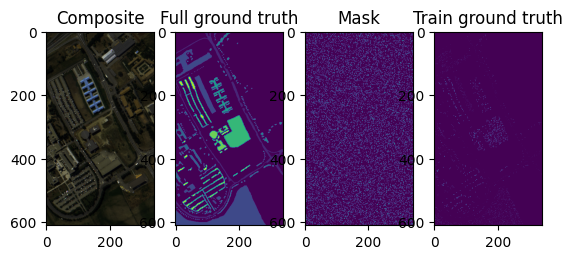

In [12]:
# 生成随机掩码，用于选择训练数据
# mask会是一个与gt形状相同的布尔数组，其中随机约5%的位置为True（True意味着选择这些样本）
mask = np.random.randint(0, 100, gt.shape) < 5

# 复制地面真值(gt)，以便创建训练样本
train_gt = np.copy(gt)

# 使用布尔掩码更新训练地面真值
# 把mask为False的位置（即gt中不属于训练样本的位置）设置为0
train_gt[np.nonzero(~mask)] = 0

# 复制地面真值(gt)，以便创建测试样本
test_gt = np.copy(gt)

# 使用训练地面真值更新测试地面真值
# 把训练集中的样本（train_gt > 0）在测试集中的对应值设置为0，
# 这样做的目的是确保训练集和测试集之间没有重叠
test_gt[train_gt > 0] = 0

rgb = img[:,:,(55,41,12)]
rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
fig = plt.figure()
fig.add_subplot(141)
plt.imshow(rgb)
plt.title("Composite")
fig.add_subplot(142)
plt.imshow(gt)
plt.title("Full ground truth")
fig.add_subplot(143)
plt.imshow(mask)
plt.title("Mask")
fig.add_subplot(144)
plt.imshow(train_gt)
plt.title("Train ground truth")
plt.show()

We define a `HyperX` class to hold the dataset. Note that the label is encoded as a one-hot vector.

In [13]:
from skimage import morphology

class HyperX(torch.utils.data.Dataset):

    def __init__(self, data, ground_truth, semi=False):
        super(HyperX, self).__init__()

        # 数值归一化，将数据规范化到[0, 1]之间
        data = (data - data.min()) / (data.max() - data.min())  # 归一化逻辑
        self.data = data  # 存储高光谱数据
        self.gt = ground_truth  # 存储地面真值数据
        self.n_classes = len(np.unique(ground_truth))  
        # ground_truth通常是一个二维数组
        # np.unique(ground_truth)会生成一个一维数组，包含ground_truth中出现的所有不同的、唯一的值

        if semi:
            # 如果是半监督学习，使用膨胀操作提取邻域索引，半径为50像素
            # morphology.disk(50) 创建半径为50的圆形结构元素
            x_pos, y_pos = np.nonzero(morphology.dilation(ground_truth > 0, morphology.disk(50)))
            #在这里，它会返回膨胀后布尔数组中所有为True（或者等价于1）的元素的坐标
            #就是返回ground_truth大于0的点以及周围的点
        else:
            # 否则仅使用非零地面真值的位置
            x_pos, y_pos = np.nonzero(ground_truth)

        # 将(x, y)坐标索引组合成列表，用于访问数据
        self.indices = [idx for idx in zip(x_pos, y_pos)]

    def __len__(self):
        # 返回数据集中样本的数量（即索引的数量）
        return len(self.indices)

    def __getitem__(self, i):
        # 根据索引获取样本的坐标
        x, y = self.indices[i]

        # 获取对应坐标的数据值
        data = self.data[x, y]  # 从数据中提取样本数据

        # 获取相应位置的标签，一般使用独热编码（one-hot encoding）
        # np.eye(self.n_classes) 创建一个单位矩阵，然后通过索引提取标签
        label = np.asarray(np.eye(self.n_classes)[self.gt[x, y]], dtype='int64')
        #获取为true点的one-hot编码的label
        
        # 将数据和标签转换为PyTorch的tensor
        return torch.from_numpy(data), torch.from_numpy(label)

In [14]:
import os
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# 基本生成器：将噪声 + 条件输入映射为生成样本
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 使用序列容器Sequential构建模型
        # LeakyReLU 激活函数允许负值梯度流动，防止死神经元
        self.generator = torch.nn.Sequential(
            # 第一个线性层，输入为噪声和条件的联合特征
            torch.nn.Linear(z_dim + c_dim, h_dim),
            torch.nn.LeakyReLU(),
            # 多个隐藏层
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            # 输出层，生成与样本特征维度相同的输出
            torch.nn.Linear(h_dim, X_dim),
            torch.nn.Sigmoid()  # 使用Sigmoid限制输出在[0, 1]之间
        )

        # 应用权重初始化函数
        self.apply(weight_init)

    def forward(self, z, c):
        # 将噪声z 和 条件c 拼接在一起，形成输入
        inputs = torch.cat([z, c], 1)
        # 通过生成器网络生成假样本
        return self.generator(inputs)

# 基本判别器：样本 -> -∞（假） - 0 - 真实（+∞）
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 使用序列容器Sequential构建判别器模型
        self.discriminator = torch.nn.Sequential(
            # 输入层，接受样本特征
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            # 隐藏层
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            # 输出层，输出一个标量来判定样本真实性
            torch.nn.Linear(h_dim, 1)
        )

        # 应用权重初始化函数
        self.apply(weight_init)

    def forward(self, X):
        # 通过判别器网络判断样本
        return self.discriminator(X)

# 基本分类器：样本 -> 类别
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # 使用序列容器Sequential构建分类器模型
        self.discriminator = torch.nn.Sequential(
            # 输入层，接受样本特征
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            # 隐藏层
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            # 输出层，输出与类别数目相同的概率分布
            torch.nn.Linear(h_dim, c_dim)
        )

        # 应用权重初始化函数
        self.apply(weight_init)

    def forward(self, X):
        # 通过分类器网络进行分类
        return self.discriminator(X)

In [15]:
# 设置训练参数
mb_size = 256            # 批次大小，表示每次训练所使用的样本数量
z_dim = 30               # 噪声的维度，表示随机噪声的长度
X_dim = img.shape[-1]   # 输入样本的特征维度，通常是图像的波段数量
h_dim = 512              # 隐藏层的尺寸，定义网络中隐藏层的节点数量
d_step = 5               # 每个生成器训练步骤前判别器训练的步骤数
lr = 5e-5                # 学习率，控制权重更新的步长
c_weight = 0.2           # 辅助分类器的权重，平衡生成器与分类器的损失
flip_percentage = 0.0    # 标签翻转比例，用于半监督学习时的数据增强
mixup_alpha = 0.1        # Mixup的超参数，用于样本混合和数据增强
semi_supervised = True    # 半监督学习（若设置为True，则包含未标记样本进行训练）

# 构建数据集和数据加载器
data_loader = torch.utils.data.DataLoader(
    HyperX(img, train_gt if semi_supervised else gt), batch_size=mb_size, shuffle=True)

# c_dim = 条件向量的大小，即类别数量
c_dim = data_loader.dataset.n_classes

# 忽略类别0（通常为背景或未标记类）
class_weights = torch.ones((c_dim))  # 创建一个大小为c_dim的全1的权重张量
class_weights[0] = 0.                 # 将类别0的权重设为0，以避免影响训练
class_weights = class_weights.cuda()   # 将权重张量移动到GPU（如果使用CUDA）

In [16]:
# 使用He et al. (2015)策略初始化权重
def weight_init(m):
    # 判断模块类型，如果是线性层或卷积层，初始化权重
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.Conv3d, nn.ConvTranspose3d)):
        torch.nn.init.kaiming_normal_(m.weight.data)

# 在单位超球面上进行球面插值
# 参考链接: https://github.com/soumith/dcgan.torch/issues/14
def slerp(val, low, high):
    # 计算low和high之间的夹角ω
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)  # 计算sin(ω)

    if so == 0:
        # 如果so为0，表示两个向量方向相同，返回线性插值
        return (1.0-val) * low + val * high  # L'Hôpital法则/LERP

    # 进行球面线性插值计算
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

# 线性插值函数
def lerp(val, low, high):
    return (1.0-val) * low + val * high  # L'Hôpital法则/LERP

# 计算改进WGAN训练中的梯度惩罚
# 来源: https://github.com/EmilienDupont/wgan-gp
# 使用建议的惩罚权重设为10
def calc_gradient_penalty(netD, real_data, generated_data, penalty_weight=10):
    #netD是一个判别器
    
    batch_size = real_data.size()[0]  # 获取真实数据的批次大小

    # alpha取值在0到1之间，用于插值
    alpha = torch.rand(batch_size, 1) if real_data.dim() == 2 else torch.rand(batch_size, 1, 1, 1)
    #如果 real_data.dim() == 2 返回 [batch_size, 1] ，否则返回 [batch_size, 1, 1, 1]
    alpha = alpha.expand_as(real_data)  # 与真实数据形状相同
    #用于返回一个形状与另一张量相同但共享同一数据的新的张量
    alpha = alpha.cuda()  # 将alpha转移到GPU上

    # 进行插值，生成混合样本
    interpolated = alpha * real_data + (1 - alpha) * generated_data
    interpolated.requires_grad_()  # 需要计算梯度
    interpolated = interpolated.cuda()  # 转移到GPU上

    # 计算插值样本的概率
    prob_interpolated = netD(interpolated)

    # 计算插值样本的概率的梯度
    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                                    create_graph=True, retain_graph=True)[0]

    # 将梯度形状转换为(batch_size, num_features)
    gradients = gradients.view(batch_size, -1)

    # 计算梯度的范数，防止接近0的情况引发问题，加入微小值epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # 返回梯度惩罚
    return penalty_weight * ((gradients_norm - 1) ** 2).mean()

# 重置多个网络的梯度
def reset_grad(*nets):
    for net in nets:
        net.zero_grad()  # 清零每个网络的梯度

# 绘制样本的均值与标准差
def plot_mean_std(samples):
    mean_spectrum = np.mean(samples, axis=0)  # 计算样本均值
    std_spectrum = np.std(samples, axis=0)    # 计算样本标准差
    plt.plot(mean_spectrum - std_spectrum, linestyle='dotted', label='-std')  # 绘制均值-标准差
    plt.plot(mean_spectrum, label='mean')  # 绘制均值
    plt.plot(mean_spectrum + std_spectrum, linestyle='dotted', label='+std')  # 绘制均值+标准差

  0%|          | 0/100000 [00:00<?, ?it/s]

Iter-0; D_loss: -1.8958134651184082; G_loss: 3.149350881576538; C_loss: 1.85308039188385


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2592\844540902.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.log_softmax(C(X))  # 对真实样本应用log_softmax


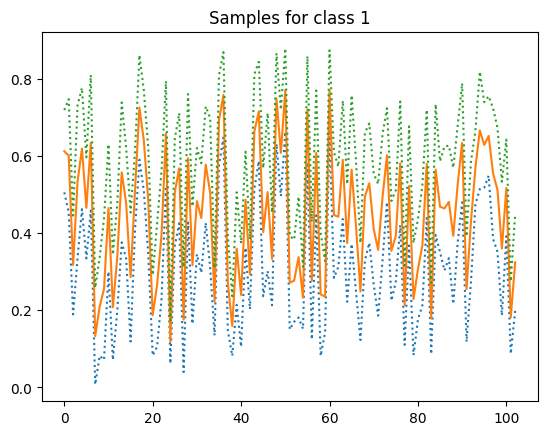

  1%|          | 999/100000 [00:53<1:19:44, 20.69it/s]

Iter-1000; D_loss: -0.26545822620391846; G_loss: -0.17826946079730988; C_loss: 0.24710606038570404


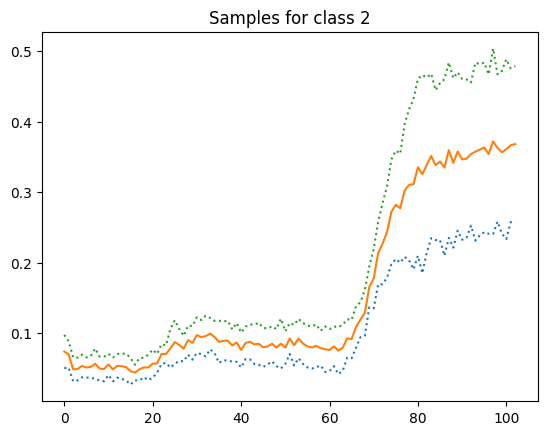

  2%|▏         | 1998/100000 [02:01<1:13:16, 22.29it/s]

Iter-2000; D_loss: -0.12911073863506317; G_loss: 0.15748552978038788; C_loss: 0.12447146326303482


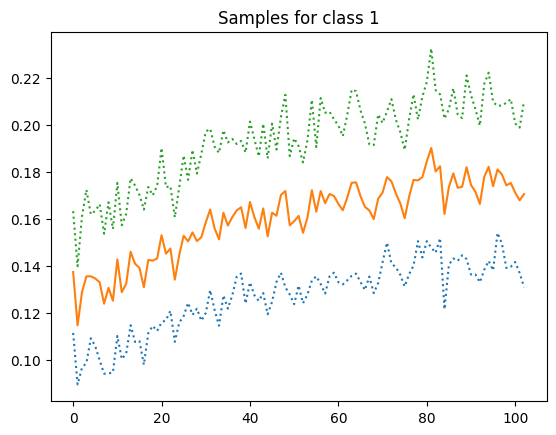

  3%|▎         | 3000/100000 [02:48<1:14:27, 21.71it/s]

Iter-3000; D_loss: -0.08294731378555298; G_loss: 0.05940507352352142; C_loss: 0.04294582083821297


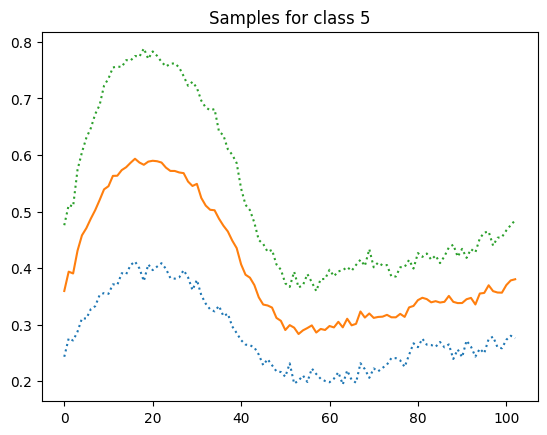

  4%|▍         | 4000/100000 [03:47<1:10:38, 22.65it/s]

Iter-4000; D_loss: -0.04749206453561783; G_loss: 0.024193936958909035; C_loss: 0.023744162172079086


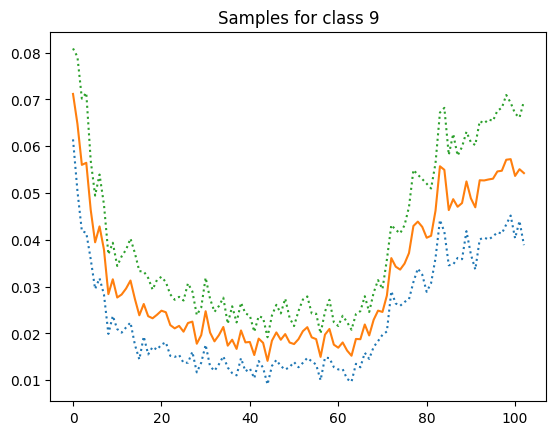

  5%|▍         | 4998/100000 [04:36<1:12:06, 21.96it/s]

Iter-5000; D_loss: -0.03958214819431305; G_loss: 0.003651704639196396; C_loss: 0.03385356813669205


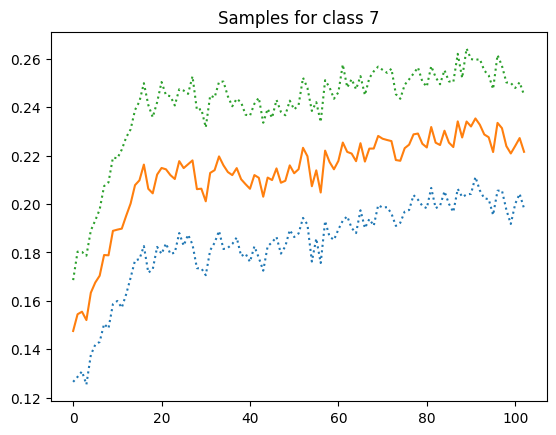

  6%|▌         | 6000/100000 [05:25<1:09:59, 22.38it/s]

Iter-6000; D_loss: -0.03920234739780426; G_loss: 0.06911677867174149; C_loss: 0.02587052807211876


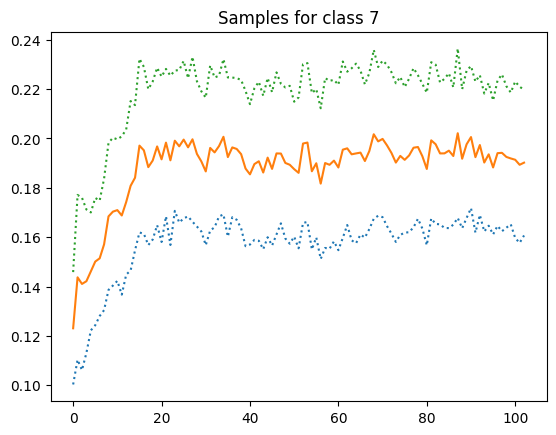

  7%|▋         | 6998/100000 [06:10<1:11:52, 21.57it/s]

Iter-7000; D_loss: -0.014515653252601624; G_loss: 0.07345809042453766; C_loss: 0.01871565170586109


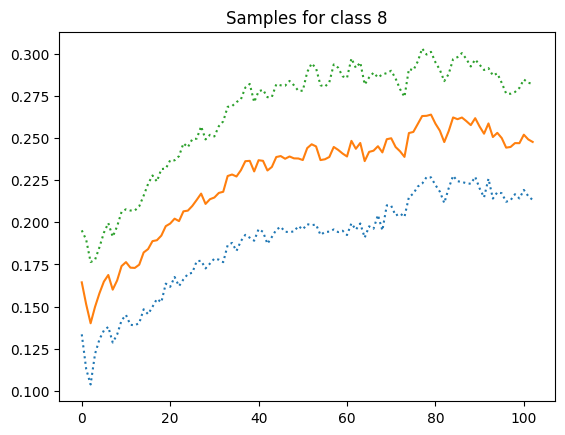

  8%|▊         | 8000/100000 [06:58<2:04:29, 12.32it/s]

Iter-8000; D_loss: -0.026475533843040466; G_loss: 0.09739866852760315; C_loss: 0.02329322136938572


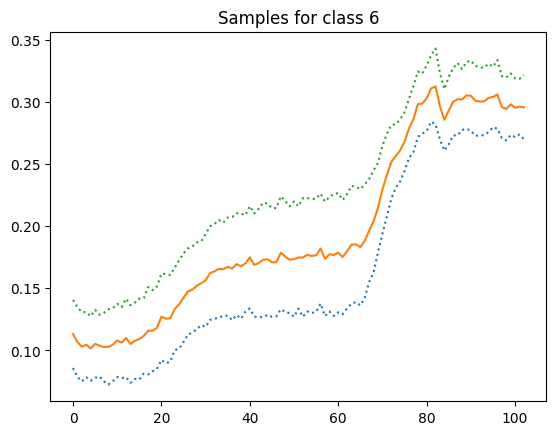

  9%|▉         | 8998/100000 [07:44<1:16:14, 19.89it/s]

Iter-9000; D_loss: -0.02183818817138672; G_loss: 0.07600844651460648; C_loss: 0.013760438188910484


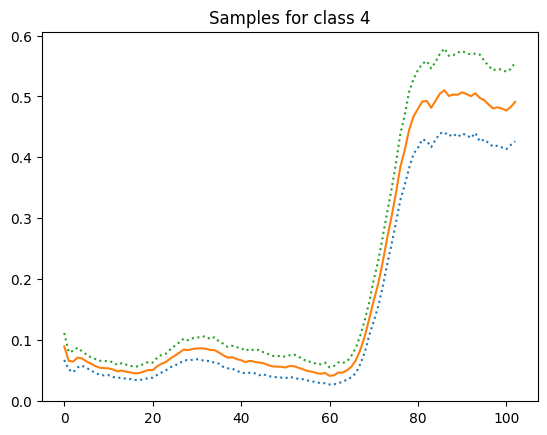

 10%|█         | 10000/100000 [08:33<1:05:27, 22.92it/s]

Iter-10000; D_loss: -0.023823419585824013; G_loss: 0.10182451456785202; C_loss: 0.01983119547367096


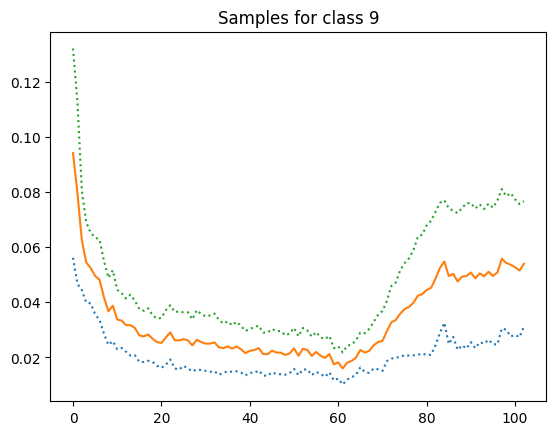

 11%|█         | 10998/100000 [09:42<1:07:17, 22.04it/s]

Iter-11000; D_loss: -0.019412899389863014; G_loss: 0.10367774218320847; C_loss: 0.012918849475681782


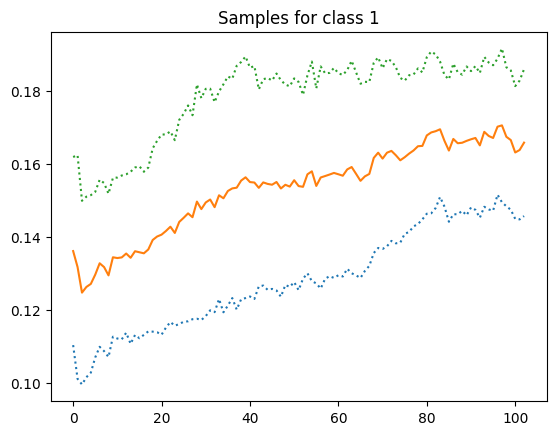

 12%|█▏        | 12000/100000 [10:32<1:05:41, 22.33it/s]

Iter-12000; D_loss: -0.027875831350684166; G_loss: 0.10106977820396423; C_loss: 0.0316045880317688


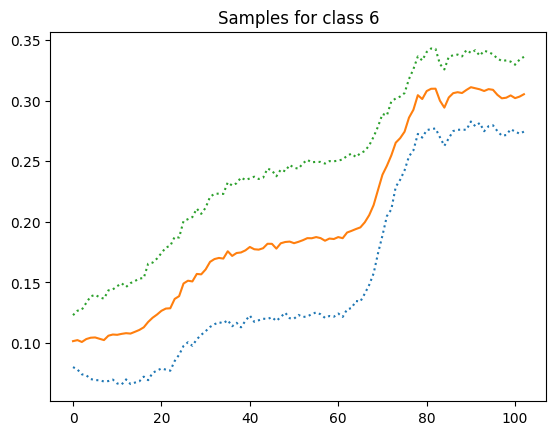

 13%|█▎        | 12999/100000 [11:19<1:14:03, 19.58it/s]

Iter-13000; D_loss: -0.014812621288001537; G_loss: 0.10055950284004211; C_loss: 0.013064609840512276


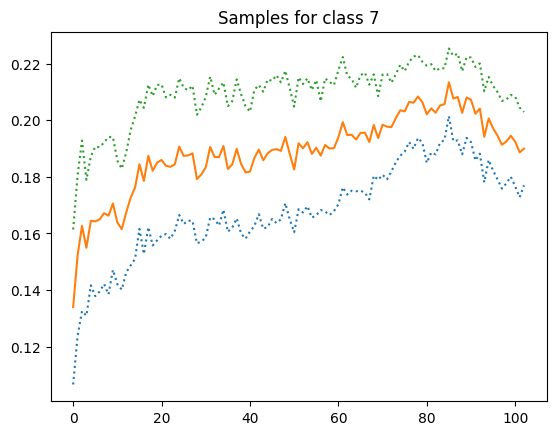

 14%|█▍        | 13999/100000 [12:17<1:38:23, 14.57it/s]

Iter-14000; D_loss: -0.015633266419172287; G_loss: 0.061514198780059814; C_loss: 0.014005177654325962


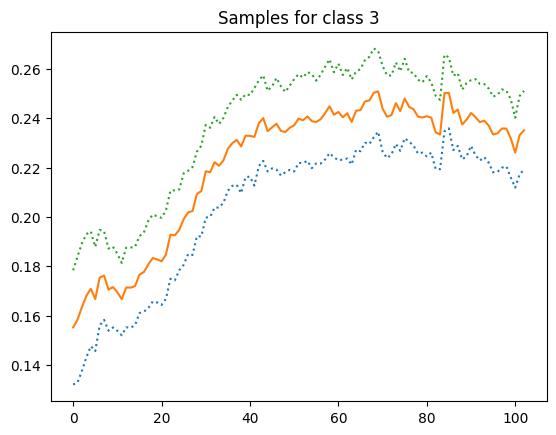

 15%|█▌        | 15000/100000 [13:08<1:08:16, 20.75it/s]

Iter-15000; D_loss: -0.017529811710119247; G_loss: 0.05313285440206528; C_loss: 0.014894945546984673


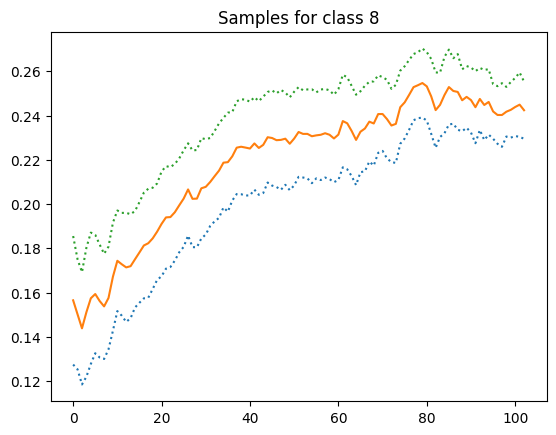

 16%|█▌        | 15998/100000 [13:52<1:00:18, 23.21it/s]

Iter-16000; D_loss: -0.0056509701535105705; G_loss: 0.03248835355043411; C_loss: 0.0201124157756567


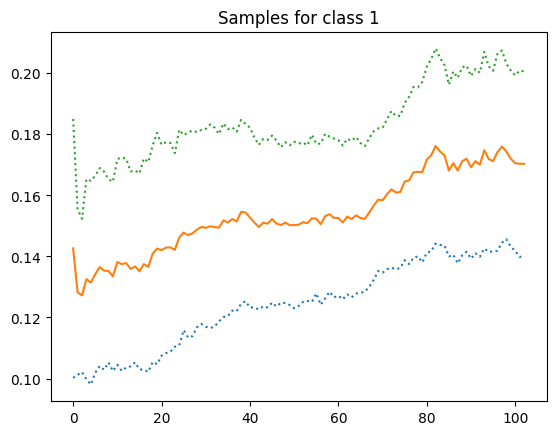

 17%|█▋        | 17000/100000 [14:37<1:05:28, 21.13it/s]

Iter-17000; D_loss: -0.010211311280727386; G_loss: 0.010647246614098549; C_loss: 0.017712857574224472


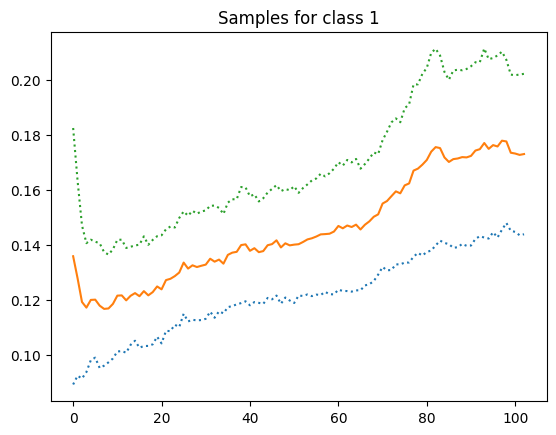

 18%|█▊        | 17999/100000 [15:27<1:20:38, 16.95it/s]

Iter-18000; D_loss: -0.00793035700917244; G_loss: 0.004622188862413168; C_loss: 0.01881624385714531


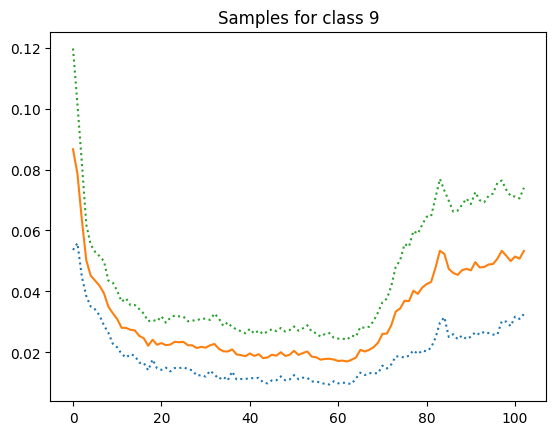

 19%|█▉        | 18998/100000 [16:14<1:07:57, 19.87it/s]

Iter-19000; D_loss: -0.011303151026368141; G_loss: -0.023378200829029083; C_loss: 0.013364506885409355


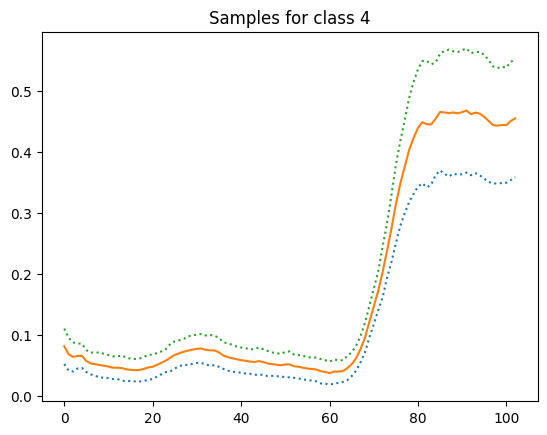

 20%|██        | 20000/100000 [17:03<58:26, 22.81it/s]  

Iter-20000; D_loss: -0.01592291332781315; G_loss: -0.03449644893407822; C_loss: 0.015447975136339664


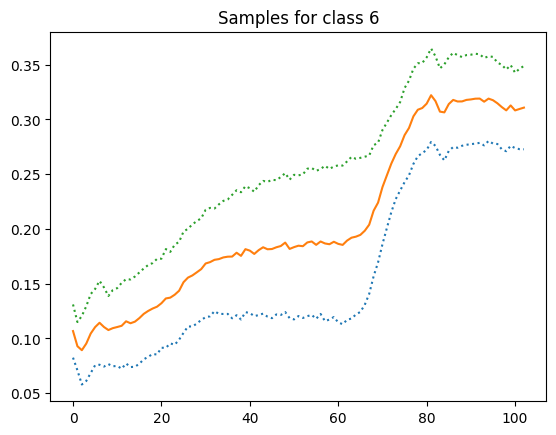

 21%|██        | 21000/100000 [18:57<5:35:59,  3.92it/s]

Iter-21000; D_loss: -0.009395938366651535; G_loss: -0.04528100788593292; C_loss: 0.012635104358196259


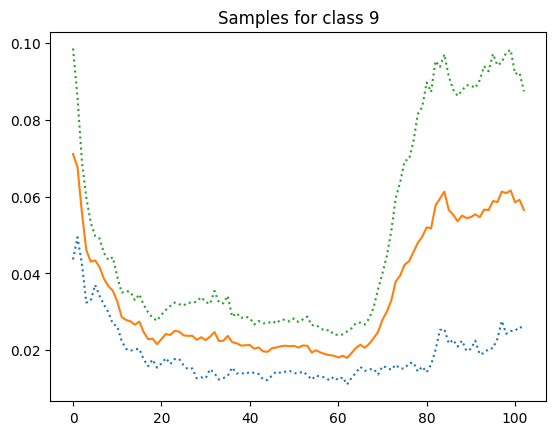

 22%|██▏       | 22000/100000 [22:43<4:52:55,  4.44it/s]

Iter-22000; D_loss: -0.012858754023909569; G_loss: -0.0548875629901886; C_loss: 0.013223022222518921


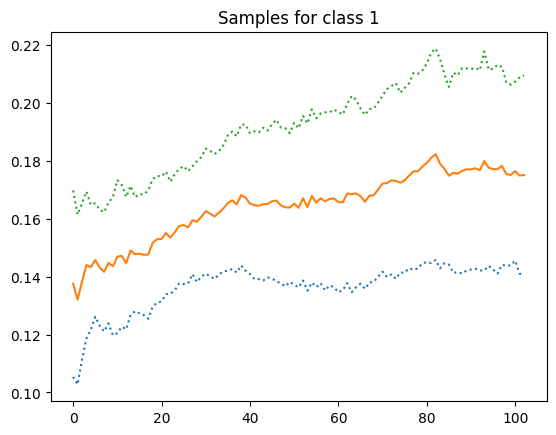

 23%|██▎       | 23000/100000 [26:26<4:27:37,  4.80it/s]

Iter-23000; D_loss: -0.008902844972908497; G_loss: -0.07239852100610733; C_loss: 0.013095330446958542


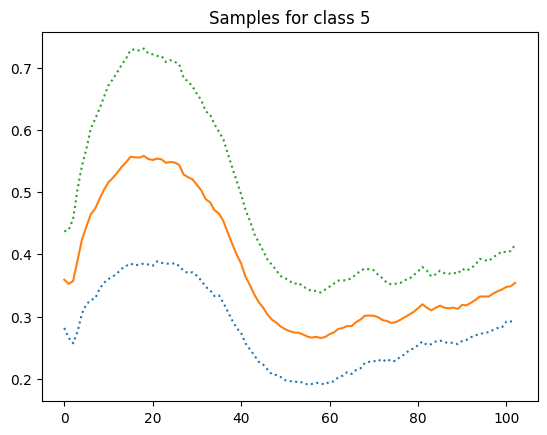

 24%|██▍       | 23999/100000 [29:15<58:39, 21.59it/s]  

Iter-24000; D_loss: -0.004530312959104776; G_loss: -0.05037567391991615; C_loss: 0.01123138889670372


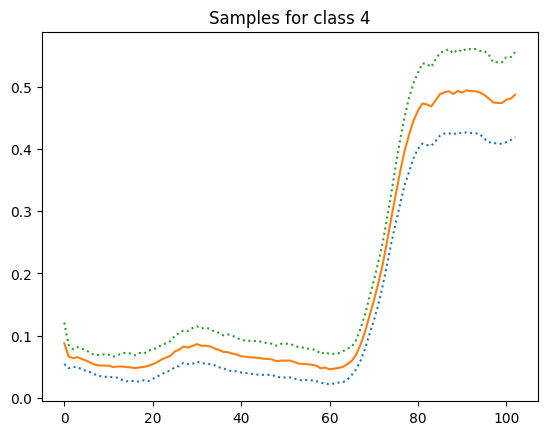

 25%|██▌       | 25000/100000 [30:58<4:55:49,  4.23it/s]

Iter-25000; D_loss: -0.011530461721122265; G_loss: -0.06504547595977783; C_loss: 0.012226780876517296


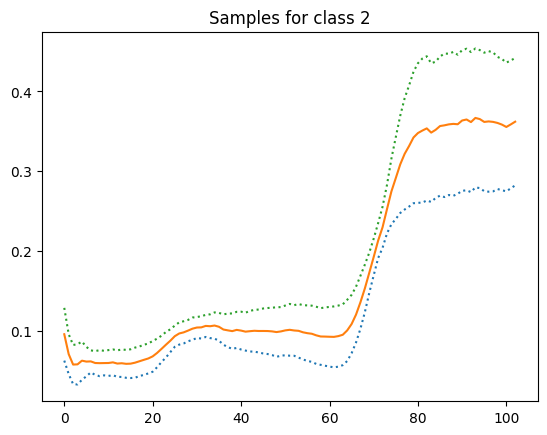

 26%|██▌       | 26000/100000 [34:43<5:29:28,  3.74it/s]

Iter-26000; D_loss: -0.011635687202215195; G_loss: -0.05872657150030136; C_loss: 0.011007227003574371


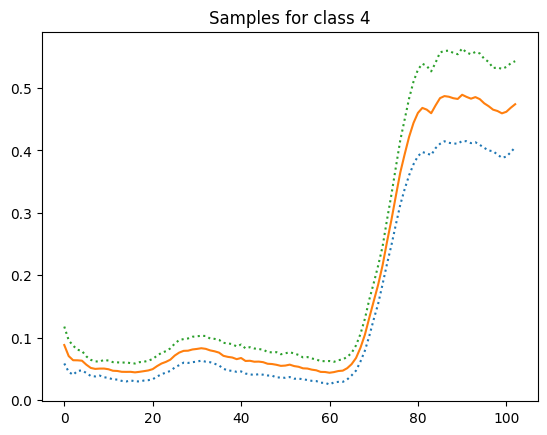

 27%|██▋       | 27000/100000 [38:47<4:40:41,  4.33it/s]

Iter-27000; D_loss: -0.009574292227625847; G_loss: -0.054303281009197235; C_loss: 0.017251774668693542


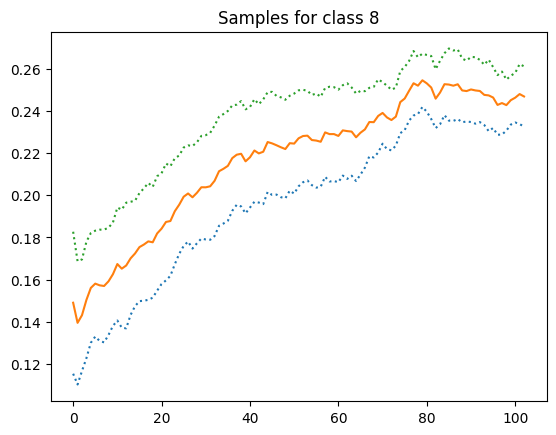

 28%|██▊       | 28000/100000 [42:45<5:05:52,  3.92it/s]

Iter-28000; D_loss: -0.013328174129128456; G_loss: -0.05026143789291382; C_loss: 0.008611039258539677


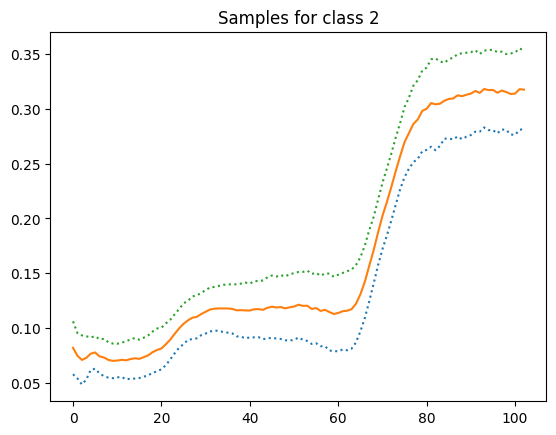

 29%|██▉       | 29000/100000 [44:12<1:09:23, 17.05it/s]

Iter-29000; D_loss: -0.011639805510640144; G_loss: -0.049399398267269135; C_loss: 0.015270359814167023


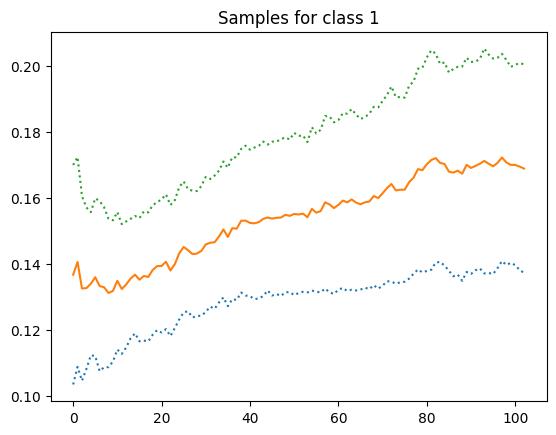

 30%|███       | 30000/100000 [47:28<4:50:56,  4.01it/s]

Iter-30000; D_loss: -0.004663296043872833; G_loss: -0.03665760159492493; C_loss: 0.019255381077528


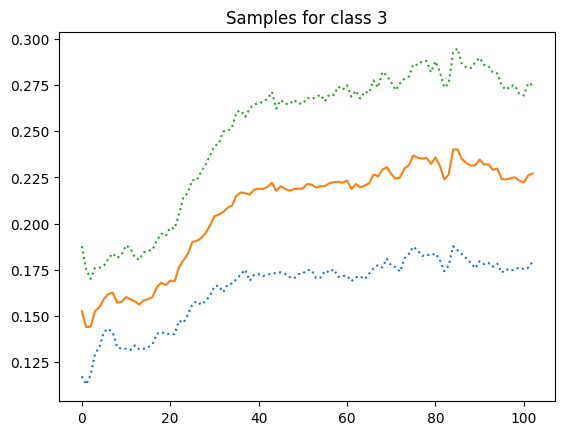

 31%|███       | 31000/100000 [51:26<4:20:53,  4.41it/s]

Iter-31000; D_loss: -0.014110781252384186; G_loss: -0.030455468222498894; C_loss: 0.019820651039481163


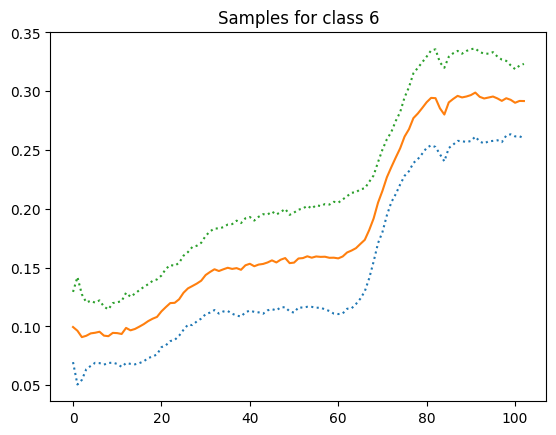

 32%|███▏      | 32000/100000 [55:31<4:36:40,  4.10it/s]

Iter-32000; D_loss: -0.012268757447600365; G_loss: -0.028298337012529373; C_loss: 0.009488408453762531


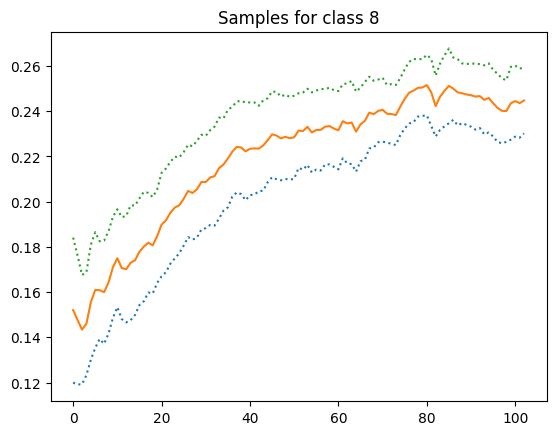

 33%|███▎      | 33000/100000 [59:43<3:32:15,  5.26it/s]

Iter-33000; D_loss: -0.014162946492433548; G_loss: -0.022874224931001663; C_loss: 0.010748707689344883


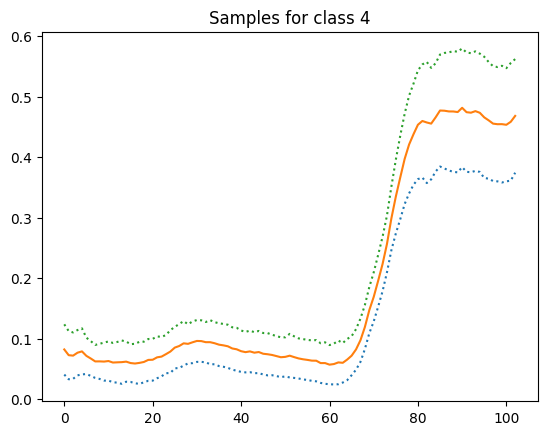

 34%|███▍      | 34000/100000 [1:03:13<3:35:29,  5.10it/s]

Iter-34000; D_loss: -0.01625177636742592; G_loss: -0.029536165297031403; C_loss: 0.011744502931833267


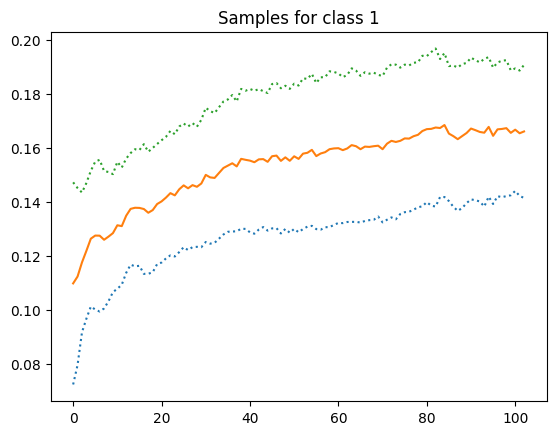

 35%|███▌      | 35000/100000 [1:05:54<3:52:58,  4.65it/s]

Iter-35000; D_loss: -0.017709383741021156; G_loss: -0.02152065932750702; C_loss: 0.007560762111097574


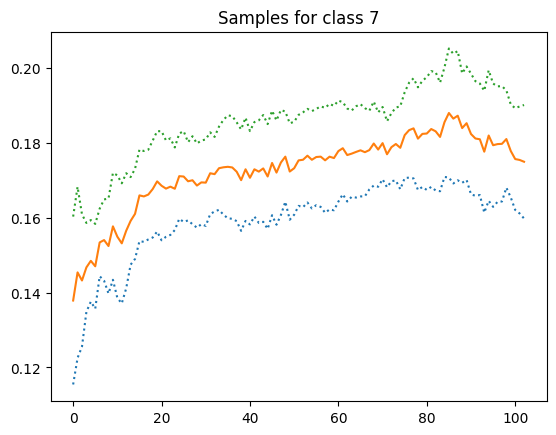

 36%|███▌      | 35999/100000 [1:07:40<56:48, 18.78it/s]  

Iter-36000; D_loss: -0.007692425511777401; G_loss: -0.012454917654395103; C_loss: 0.012495920993387699


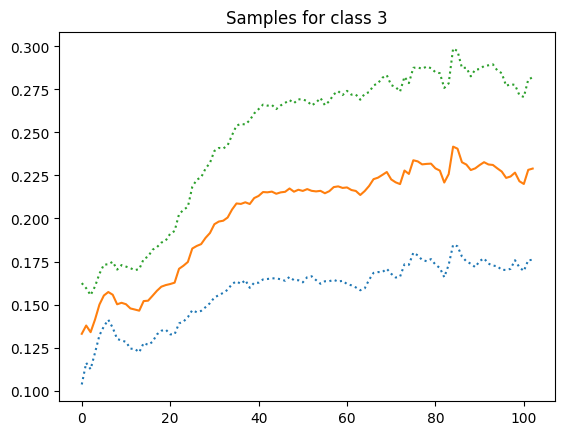

 37%|███▋      | 37000/100000 [1:09:04<3:26:44,  5.08it/s]

Iter-37000; D_loss: -0.008512908592820168; G_loss: -0.015566297806799412; C_loss: 0.01255641970783472


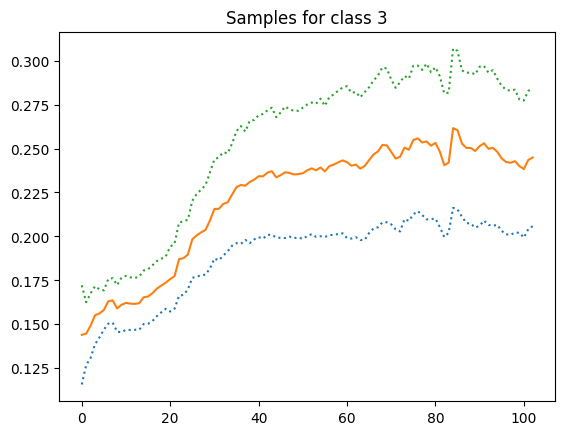

 38%|███▊      | 38000/100000 [1:11:07<49:47, 20.75it/s]  

Iter-38000; D_loss: -0.012672089971601963; G_loss: -0.022173643112182617; C_loss: 0.008147912099957466


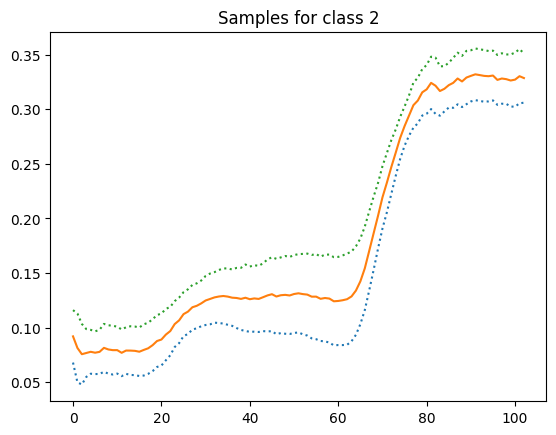

 39%|███▉      | 38999/100000 [1:11:53<46:36, 21.81it/s]

Iter-39000; D_loss: -0.00848165899515152; G_loss: -0.02810923010110855; C_loss: 0.007620099000632763


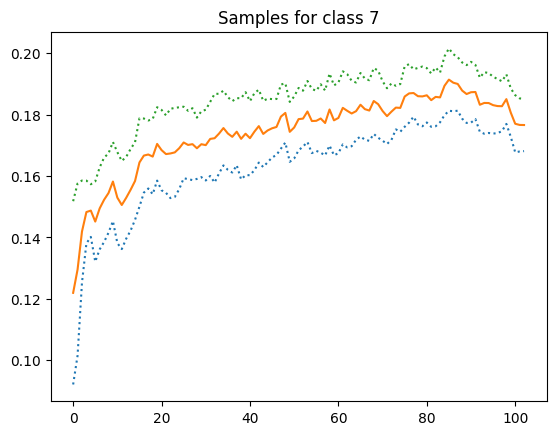

 40%|███▉      | 39999/100000 [1:12:39<47:23, 21.10it/s]

Iter-40000; D_loss: -0.01276774425059557; G_loss: -0.015566880814731121; C_loss: 0.01108196284621954


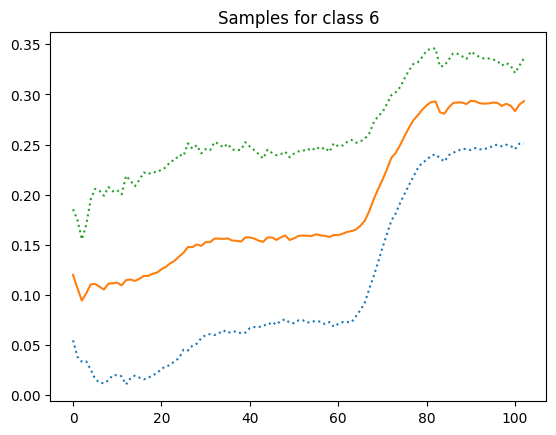

 41%|████      | 41000/100000 [1:13:25<45:31, 21.60it/s]

Iter-41000; D_loss: -0.012533237226307392; G_loss: -0.011406333185732365; C_loss: 0.01629599556326866


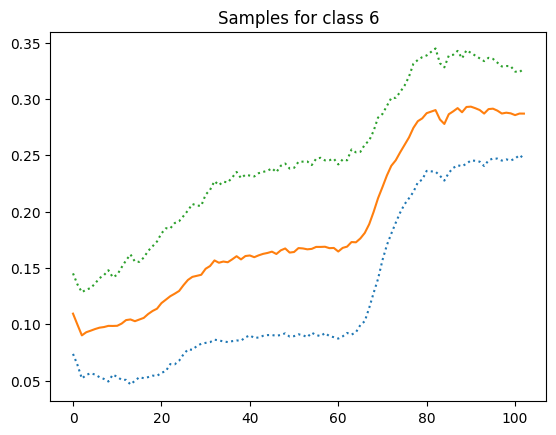

 42%|████▏     | 42000/100000 [1:14:11<43:31, 22.21it/s]

Iter-42000; D_loss: -0.011159056797623634; G_loss: -0.021969661116600037; C_loss: 0.012297217734158039


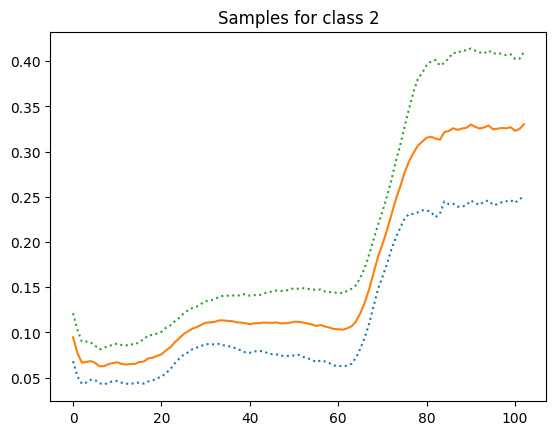

 43%|████▎     | 43000/100000 [1:14:57<45:57, 20.67it/s]

Iter-43000; D_loss: -0.00901935063302517; G_loss: -0.010094331577420235; C_loss: 0.014290457591414452


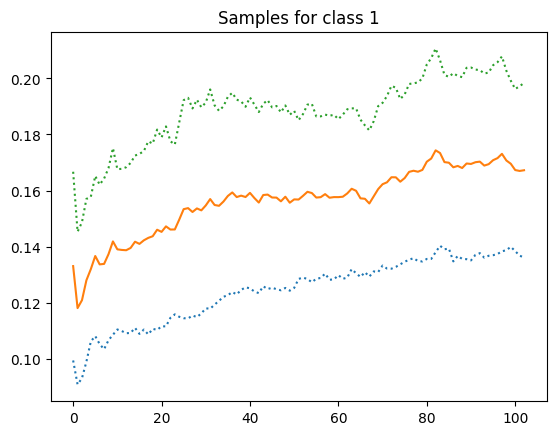

 44%|████▍     | 44000/100000 [1:15:43<42:36, 21.90it/s]

Iter-44000; D_loss: -0.01900700479745865; G_loss: -0.020802095532417297; C_loss: 0.01566384918987751


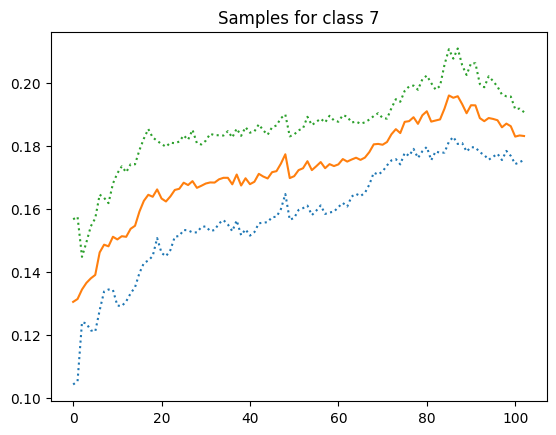

 45%|████▍     | 44999/100000 [1:16:28<42:02, 21.81it/s]

Iter-45000; D_loss: -0.009091837331652641; G_loss: -0.007890727370977402; C_loss: 0.012948821298778057


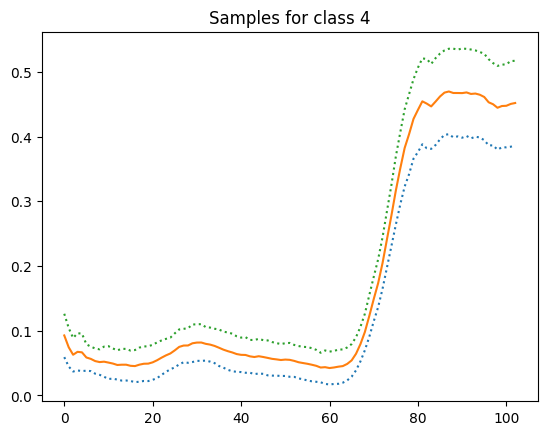

 46%|████▌     | 46000/100000 [1:17:14<39:04, 23.03it/s]

Iter-46000; D_loss: -0.01197437196969986; G_loss: -0.011628827080130577; C_loss: 0.008811594918370247


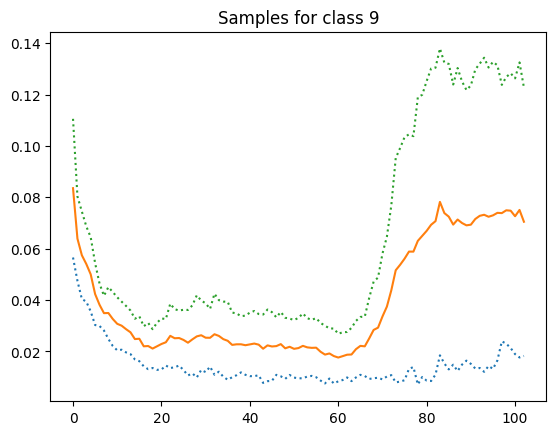

 47%|████▋     | 46998/100000 [1:17:59<43:32, 20.28it/s]

Iter-47000; D_loss: -0.003060512710362673; G_loss: -0.024806512519717216; C_loss: 0.010867075063288212


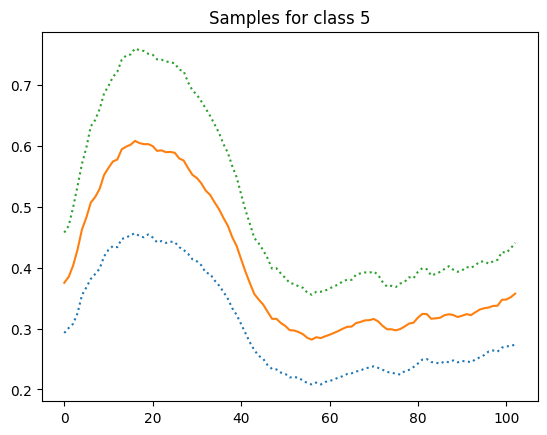

 48%|████▊     | 47999/100000 [1:18:45<39:44, 21.81it/s]

Iter-48000; D_loss: -0.016854669898748398; G_loss: -0.010589951649308205; C_loss: 0.012872694060206413


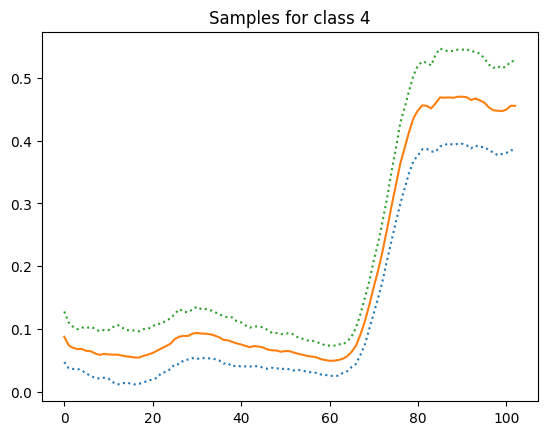

 49%|████▉     | 48999/100000 [1:19:31<38:16, 22.21it/s]

Iter-49000; D_loss: -0.007574350573122501; G_loss: -0.026130937039852142; C_loss: 0.009088304825127125


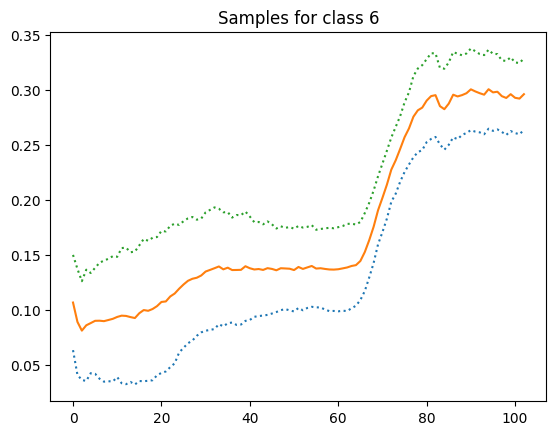

 50%|████▉     | 49998/100000 [1:20:17<36:54, 22.58it/s]

Iter-50000; D_loss: -0.010630150325596333; G_loss: -0.004709696397185326; C_loss: 0.012280914932489395


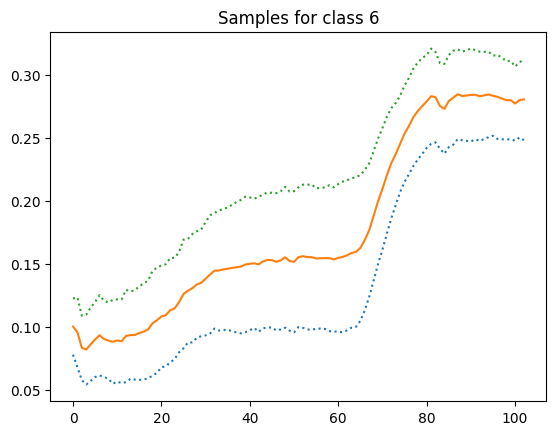

 51%|█████     | 50998/100000 [1:21:11<39:08, 20.86it/s]  

Iter-51000; D_loss: -0.012176807038486004; G_loss: 0.0009796597296372056; C_loss: 0.013026467524468899


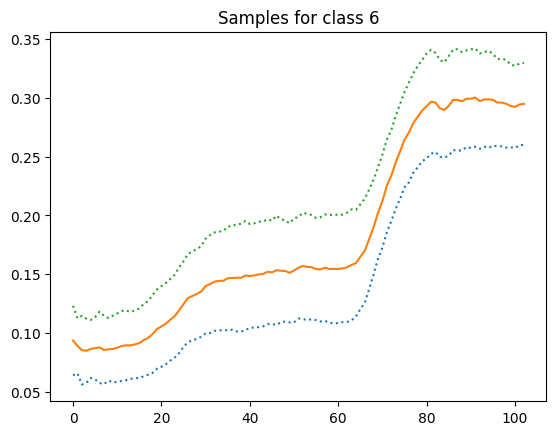

 52%|█████▏    | 52000/100000 [1:21:57<37:12, 21.50it/s]

Iter-52000; D_loss: -0.0036507360637187958; G_loss: 0.004580182954668999; C_loss: 0.01834317110478878


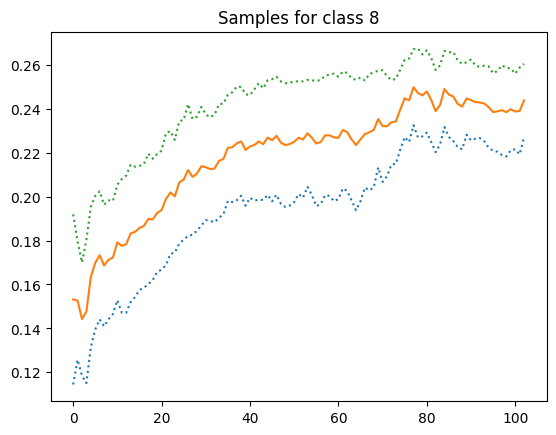

 53%|█████▎    | 53000/100000 [1:22:43<35:32, 22.04it/s]

Iter-53000; D_loss: -0.010356082580983639; G_loss: -0.011984273791313171; C_loss: 0.009459646418690681


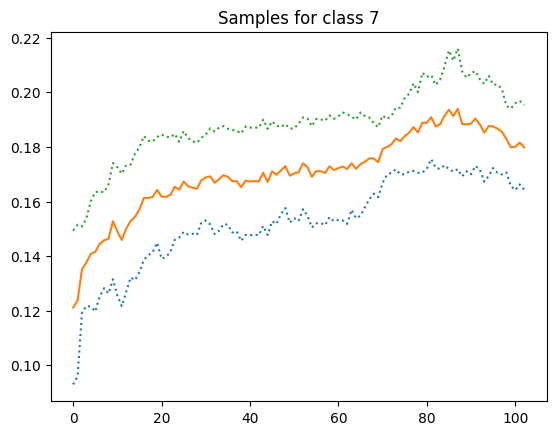

 54%|█████▍    | 53998/100000 [1:23:29<33:33, 22.85it/s]

Iter-54000; D_loss: -0.0059095583856105804; G_loss: -0.011700189672410488; C_loss: 0.017057862132787704


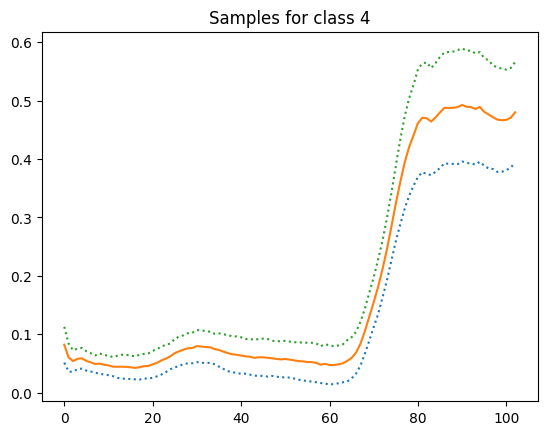

 55%|█████▌    | 55000/100000 [1:24:15<35:21, 21.21it/s]

Iter-55000; D_loss: -0.01616576872766018; G_loss: -0.014772064983844757; C_loss: 0.012540224939584732


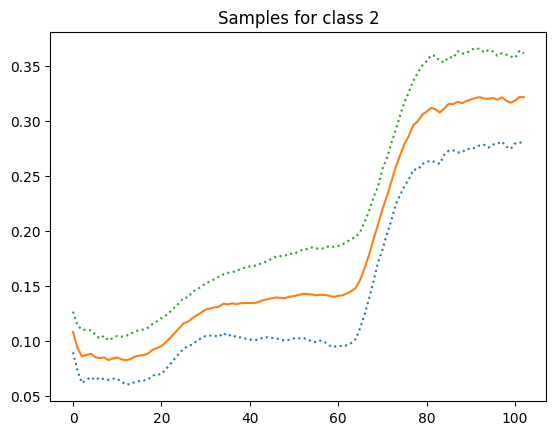

 56%|█████▌    | 55999/100000 [1:25:02<36:03, 20.33it/s]

Iter-56000; D_loss: -0.014916423708200455; G_loss: 0.005458199419081211; C_loss: 0.011516446247696877


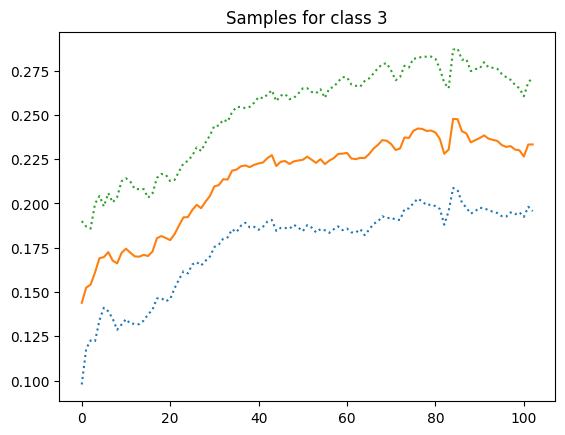

 57%|█████▋    | 57000/100000 [1:25:51<34:15, 20.92it/s]

Iter-57000; D_loss: -0.009286778047680855; G_loss: -0.013171490281820297; C_loss: 0.007798290811479092


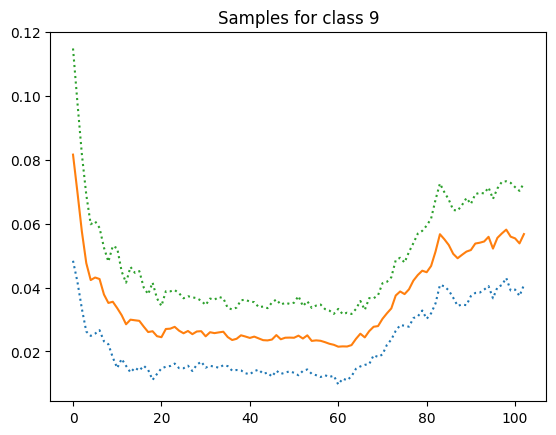

 58%|█████▊    | 57999/100000 [1:26:42<30:43, 22.79it/s]

Iter-58000; D_loss: -0.014846671372652054; G_loss: -0.028213361278176308; C_loss: 0.01255438569933176


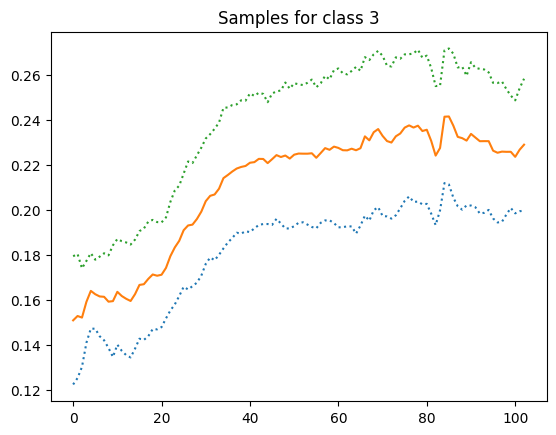

 59%|█████▉    | 58998/100000 [1:27:28<33:04, 20.66it/s]

Iter-59000; D_loss: -0.006244179327040911; G_loss: -0.02695850096642971; C_loss: 0.012238151393830776


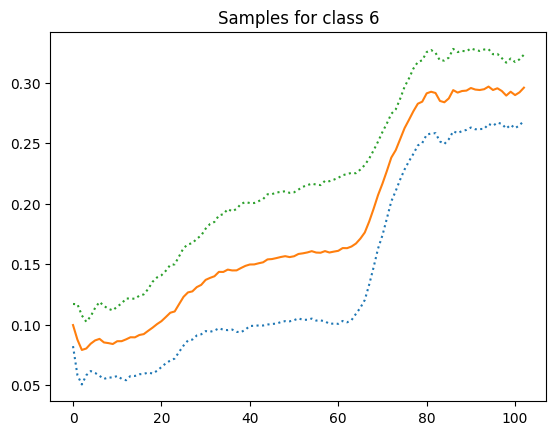

 60%|██████    | 60000/100000 [1:28:14<31:06, 21.43it/s]

Iter-60000; D_loss: 0.0007805638015270233; G_loss: -0.028299812227487564; C_loss: 0.01877710409462452


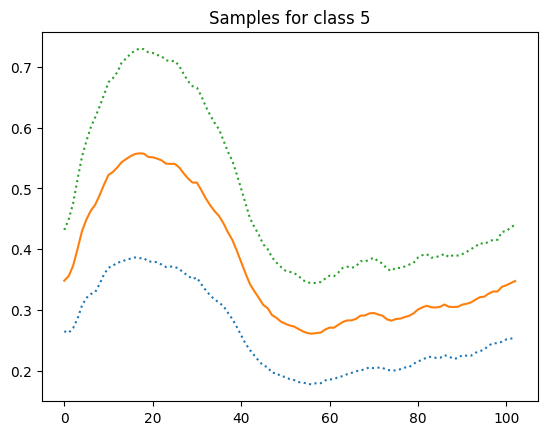

 61%|██████    | 60998/100000 [1:28:58<29:24, 22.11it/s]

Iter-61000; D_loss: -0.012577177956700325; G_loss: -0.021220728754997253; C_loss: 0.010742818005383015


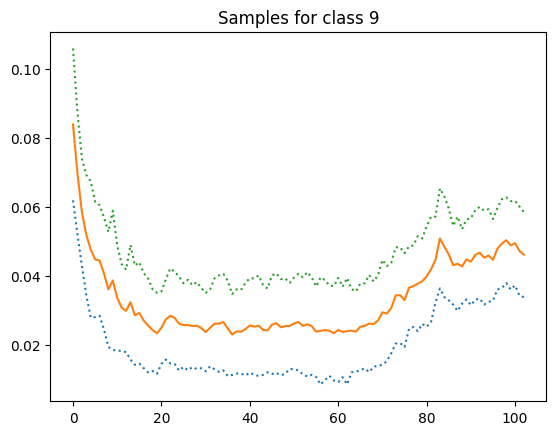

 62%|██████▏   | 61998/100000 [1:29:45<28:21, 22.33it/s]

Iter-62000; D_loss: -0.01494668796658516; G_loss: -0.02623346447944641; C_loss: 0.010234763845801353


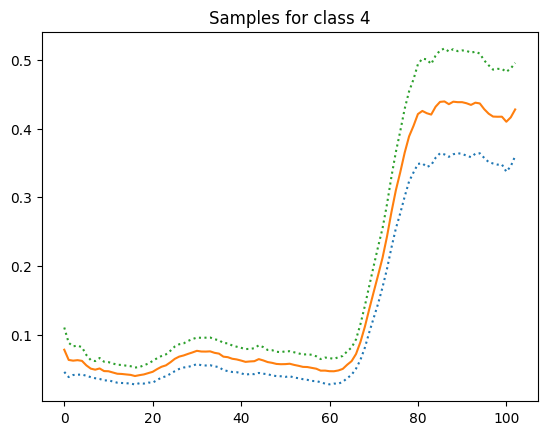

 63%|██████▎   | 62999/100000 [1:30:31<27:36, 22.33it/s]

Iter-63000; D_loss: -0.008276795037090778; G_loss: -0.0300869420170784; C_loss: 0.010730339214205742


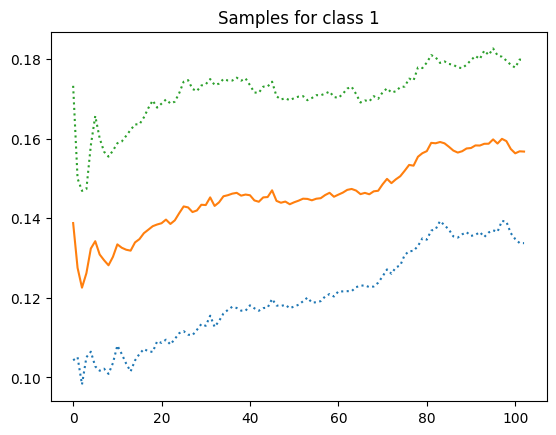

 64%|██████▍   | 63998/100000 [1:31:16<27:04, 22.16it/s]

Iter-64000; D_loss: 0.0020444095134735107; G_loss: -0.012514768168330193; C_loss: 0.020087191835045815


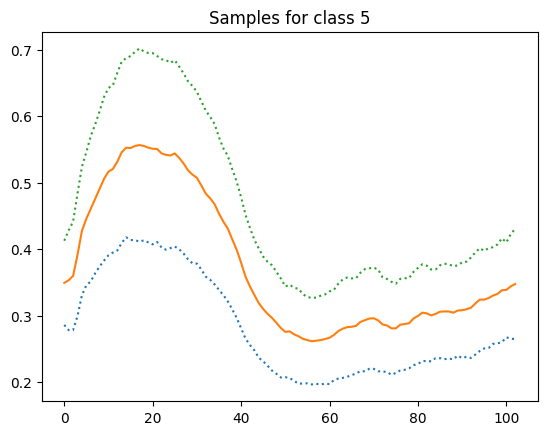

 65%|██████▍   | 64999/100000 [1:32:02<28:04, 20.78it/s]

Iter-65000; D_loss: -0.0055423397570848465; G_loss: -0.033351264894008636; C_loss: 0.014691133052110672


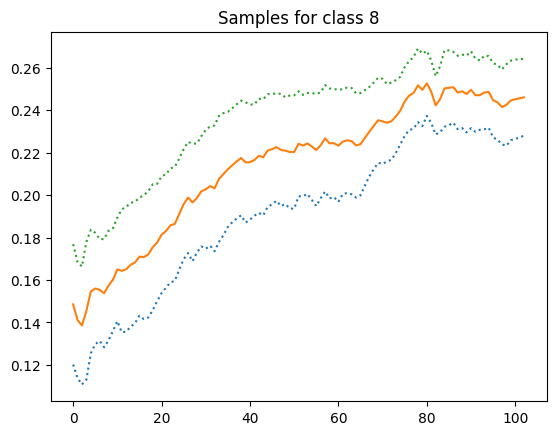

 66%|██████▌   | 65998/100000 [1:32:49<26:01, 21.77it/s]

Iter-66000; D_loss: -0.008522048592567444; G_loss: -0.021387003362178802; C_loss: 0.012715899385511875


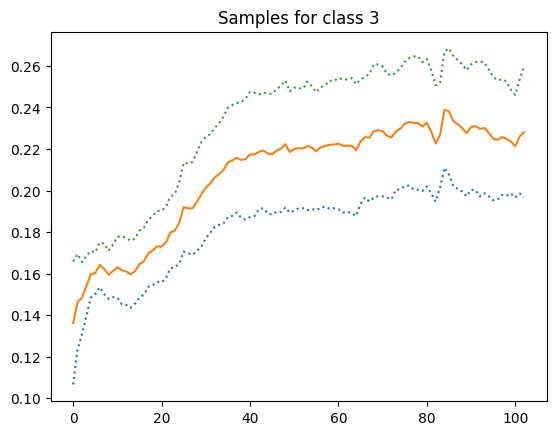

 67%|██████▋   | 67000/100000 [1:33:34<24:58, 22.02it/s]

Iter-67000; D_loss: -0.005477794446051121; G_loss: -0.030464239418506622; C_loss: 0.009303697384893894


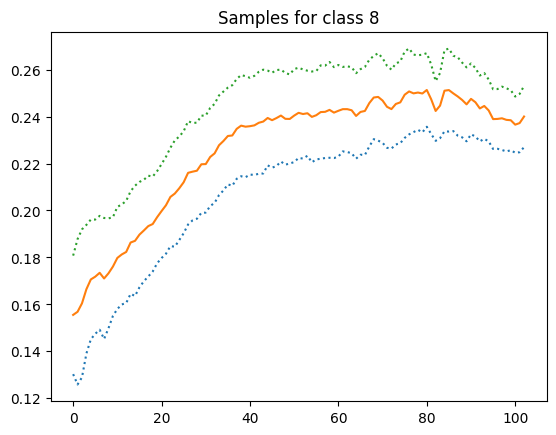

 68%|██████▊   | 67998/100000 [1:34:20<23:25, 22.78it/s]

Iter-68000; D_loss: -0.008527367375791073; G_loss: -0.016598284244537354; C_loss: 0.00987494457513094


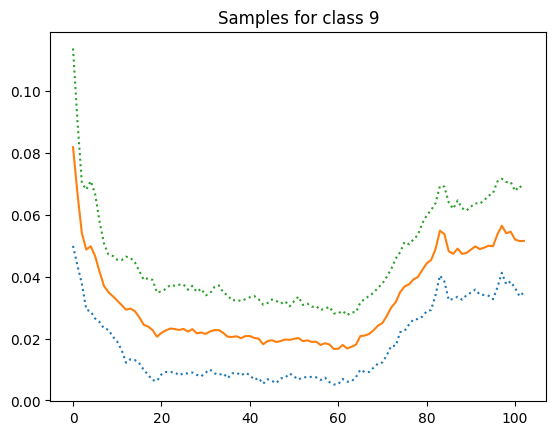

 69%|██████▉   | 68998/100000 [1:35:06<23:33, 21.93it/s]

Iter-69000; D_loss: -0.012531963177025318; G_loss: -0.029437847435474396; C_loss: 0.008968092501163483


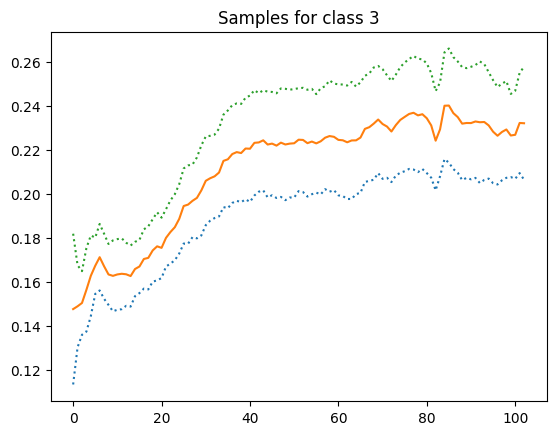

 70%|██████▉   | 69998/100000 [1:36:03<22:50, 21.89it/s]  

Iter-70000; D_loss: -0.014879850670695305; G_loss: -0.020762095227837563; C_loss: 0.015548905357718468


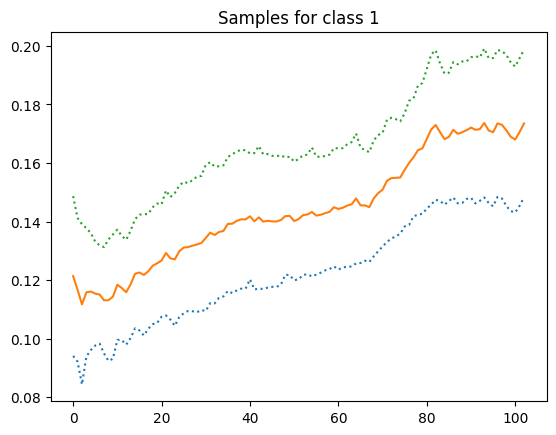

 71%|███████   | 70999/100000 [1:36:50<22:26, 21.55it/s]

Iter-71000; D_loss: -0.0101371044293046; G_loss: -0.02300877869129181; C_loss: 0.010560590773820877


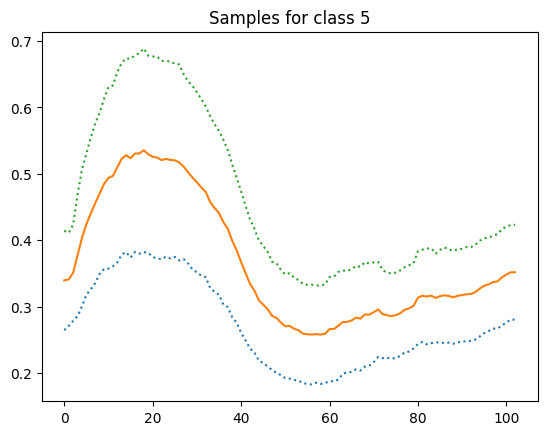

 72%|███████▏  | 71998/100000 [1:37:36<21:57, 21.26it/s]

Iter-72000; D_loss: -0.019618051126599312; G_loss: -0.01834281161427498; C_loss: 0.035255830734968185


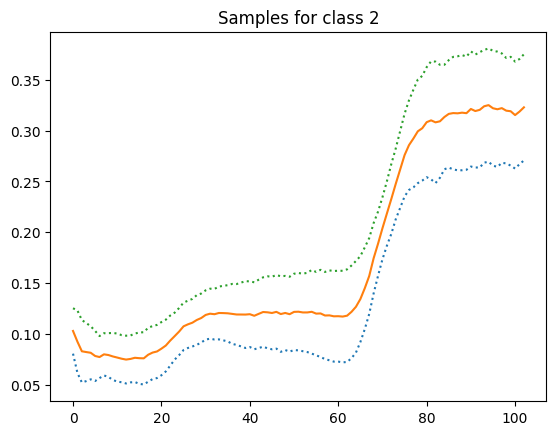

 73%|███████▎  | 72999/100000 [1:38:21<20:47, 21.64it/s]

Iter-73000; D_loss: -0.012296602129936218; G_loss: -0.027661673724651337; C_loss: 0.011919097974896431


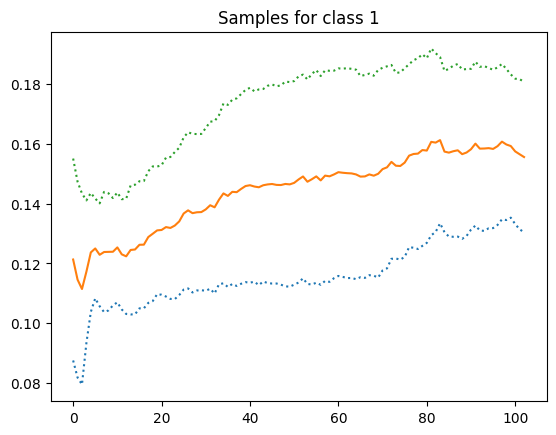

 74%|███████▍  | 74000/100000 [1:39:06<19:39, 22.04it/s]

Iter-74000; D_loss: -0.021849436685442924; G_loss: -0.019786885008215904; C_loss: 0.01208864338696003


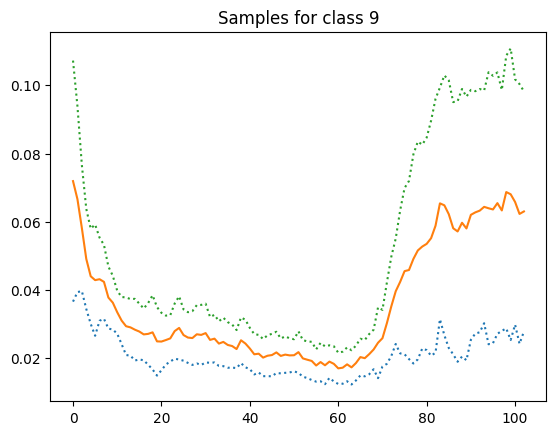

 75%|███████▍  | 74999/100000 [1:39:52<18:45, 22.21it/s]

Iter-75000; D_loss: -0.0071322862058877945; G_loss: -0.02374286577105522; C_loss: 0.013006267137825489


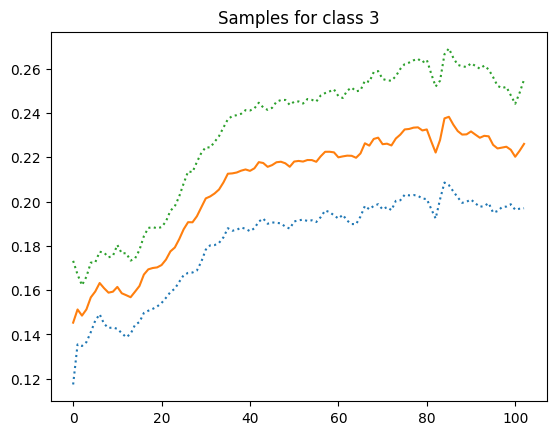

 76%|███████▌  | 76000/100000 [1:40:38<18:14, 21.93it/s]

Iter-76000; D_loss: -0.014453571289777756; G_loss: -0.033127643167972565; C_loss: 0.015138112008571625


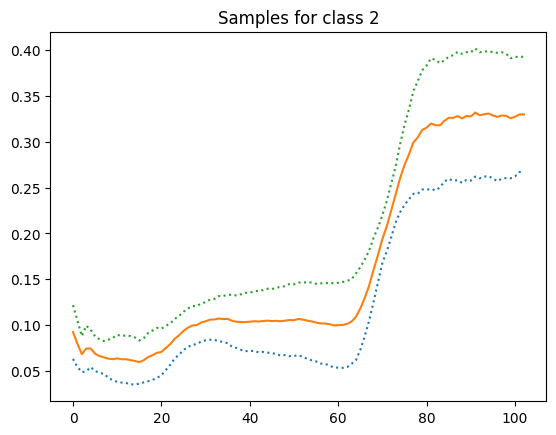

 77%|███████▋  | 77000/100000 [1:41:23<17:33, 21.83it/s]

Iter-77000; D_loss: -0.014235824346542358; G_loss: -0.03132953122258186; C_loss: 0.008037939667701721


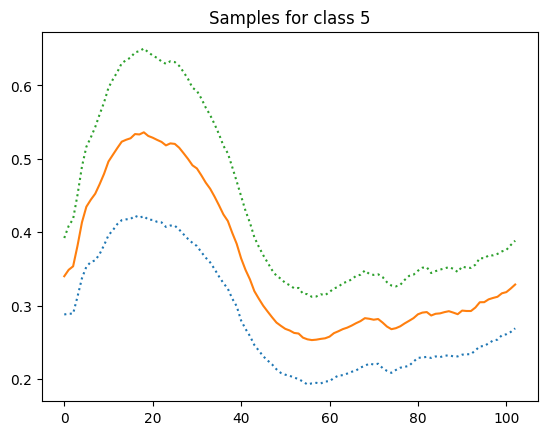

 78%|███████▊  | 78000/100000 [1:42:09<17:32, 20.90it/s]

Iter-78000; D_loss: -0.012697558850049973; G_loss: -0.023193951696157455; C_loss: 0.01328540500253439


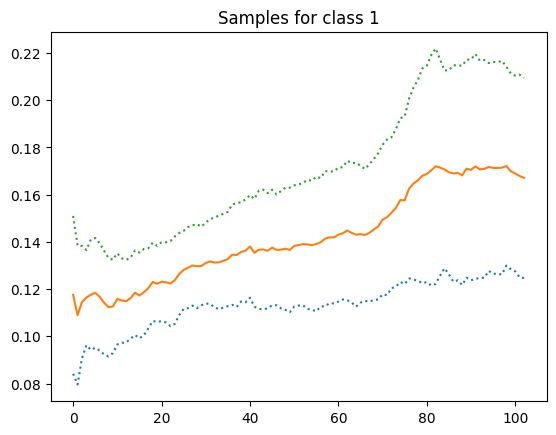

 79%|███████▉  | 78999/100000 [1:42:54<16:19, 21.43it/s]

Iter-79000; D_loss: -0.0074822078458964825; G_loss: -0.03128768876194954; C_loss: 0.012550679966807365


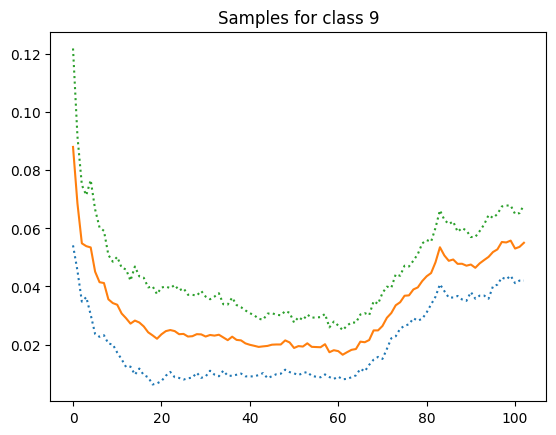

 80%|███████▉  | 79999/100000 [1:43:40<15:18, 21.77it/s]

Iter-80000; D_loss: -0.011386731639504433; G_loss: -0.03251875191926956; C_loss: 0.008215601556003094


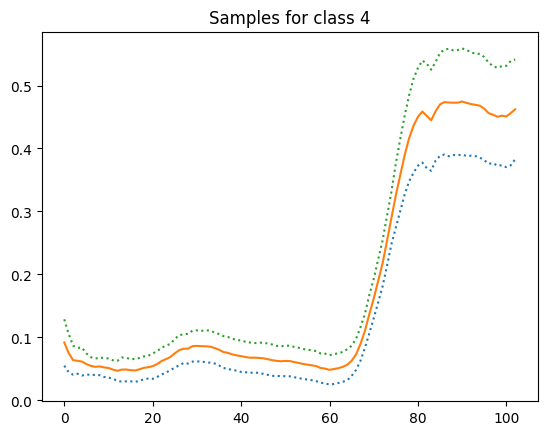

 81%|████████  | 80998/100000 [1:44:26<14:16, 22.19it/s]

Iter-81000; D_loss: -0.013330221176147461; G_loss: -0.03749152272939682; C_loss: 0.012101300992071629


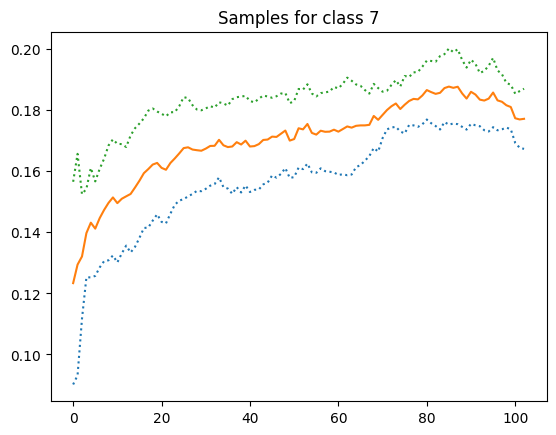

 82%|████████▏ | 82000/100000 [1:45:11<13:19, 22.52it/s]

Iter-82000; D_loss: -0.008429249748587608; G_loss: -0.035754457116127014; C_loss: 0.009865457192063332


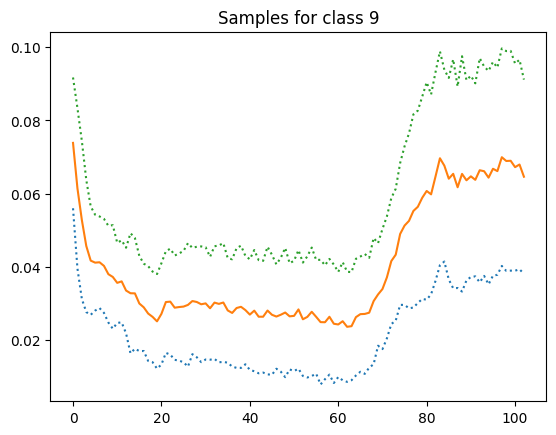

 83%|████████▎ | 82999/100000 [1:45:57<12:31, 22.63it/s]

Iter-83000; D_loss: -0.01205879170447588; G_loss: -0.03769226372241974; C_loss: 0.009152770973742008


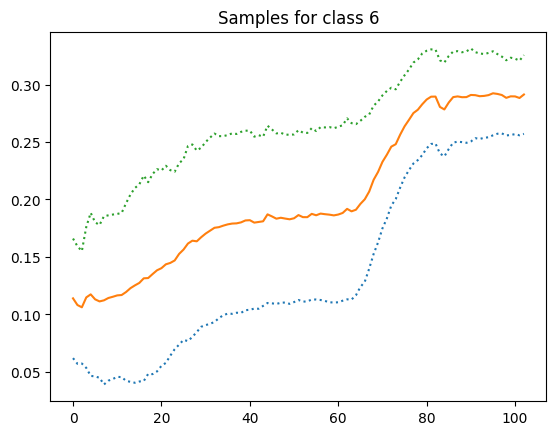

 84%|████████▍ | 83999/100000 [1:46:43<11:56, 22.32it/s]

Iter-84000; D_loss: -0.008241930976510048; G_loss: -0.03418918699026108; C_loss: 0.008265821263194084


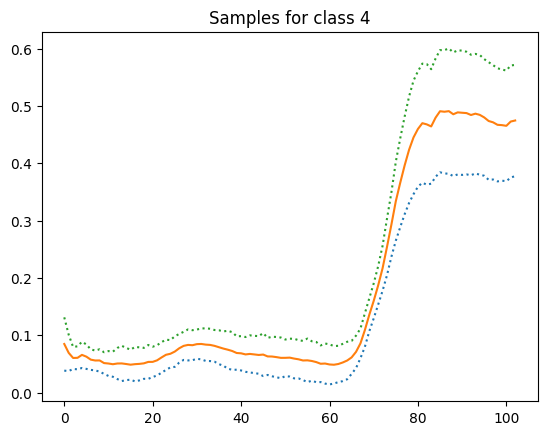

 85%|████████▍ | 84999/100000 [1:47:29<11:14, 22.23it/s]

Iter-85000; D_loss: -0.010073000565171242; G_loss: -0.03516700118780136; C_loss: 0.011668882332742214


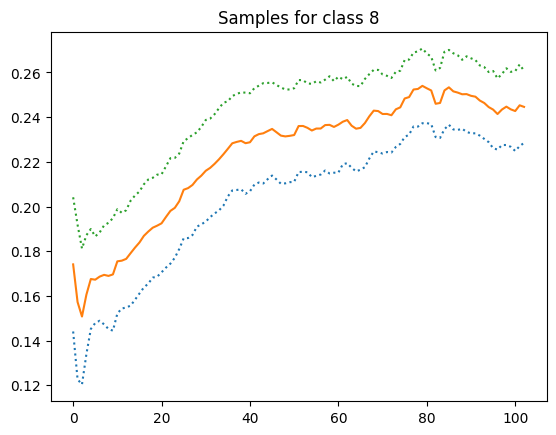

 86%|████████▌ | 86000/100000 [1:48:15<10:37, 21.96it/s]

Iter-86000; D_loss: -0.008997087366878986; G_loss: -0.03654007613658905; C_loss: 0.009541620500385761


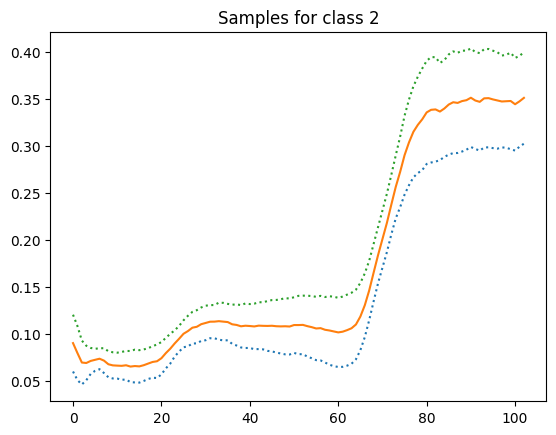

 87%|████████▋ | 86998/100000 [1:49:00<09:47, 22.13it/s]

Iter-87000; D_loss: -0.011082135140895844; G_loss: -0.039261650294065475; C_loss: 0.011107024736702442


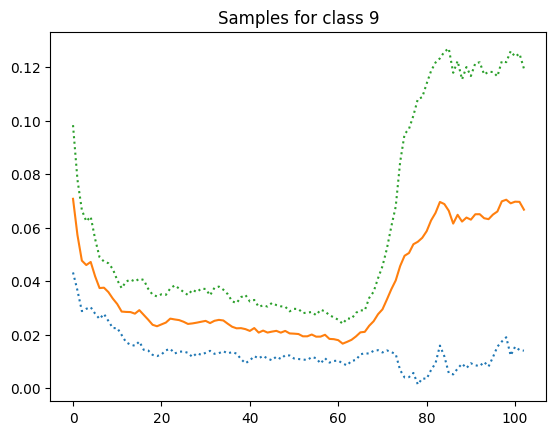

 88%|████████▊ | 88000/100000 [1:49:47<09:10, 21.80it/s]

Iter-88000; D_loss: -0.014886653050780296; G_loss: -0.048040635883808136; C_loss: 0.008585527539253235


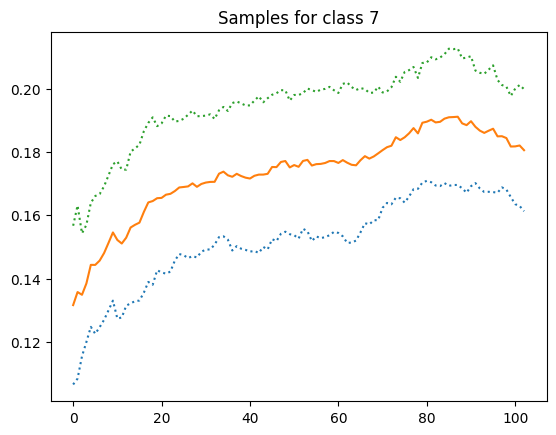

 89%|████████▉ | 88998/100000 [1:50:32<08:09, 22.47it/s]

Iter-89000; D_loss: -0.007630370557308197; G_loss: -0.04652850702404976; C_loss: 0.009466693736612797


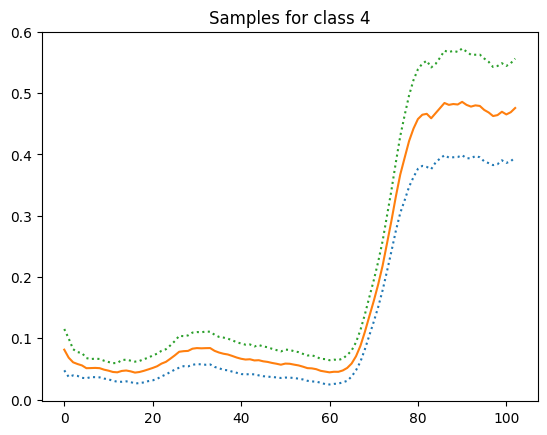

 90%|█████████ | 90000/100000 [1:51:19<07:33, 22.04it/s]

Iter-90000; D_loss: -0.010992379859089851; G_loss: -0.05054762586951256; C_loss: 0.010124986991286278


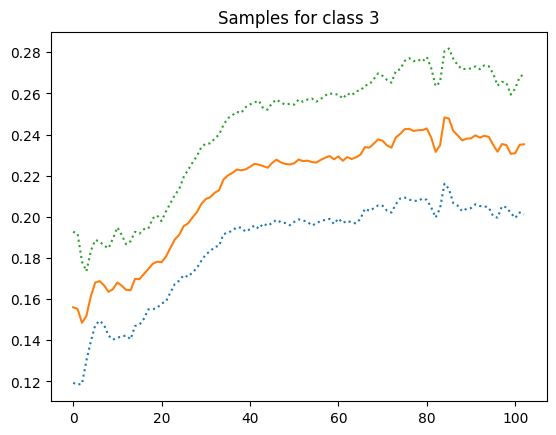

 91%|█████████ | 90998/100000 [1:52:08<06:42, 22.37it/s]

Iter-91000; D_loss: -0.009036406874656677; G_loss: -0.05944051221013069; C_loss: 0.010940168984234333


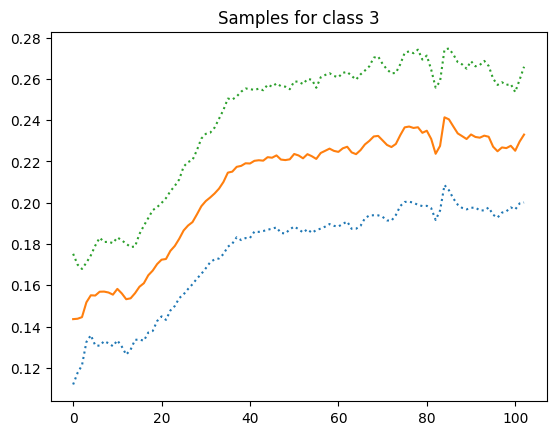

 92%|█████████▏| 92000/100000 [1:52:54<06:04, 21.97it/s]

Iter-92000; D_loss: -0.011692240834236145; G_loss: -0.04880528151988983; C_loss: 0.010713398456573486


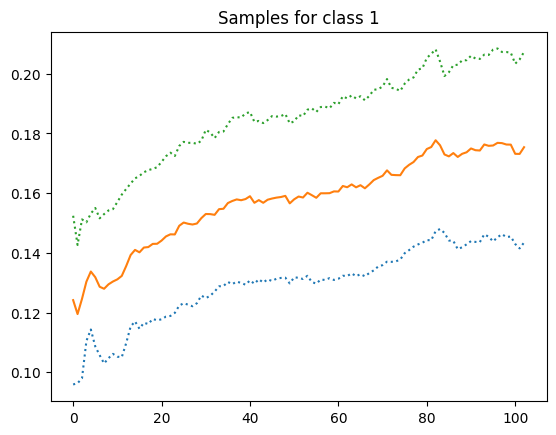

 93%|█████████▎| 92998/100000 [1:53:39<05:14, 22.26it/s]

Iter-93000; D_loss: -0.011163531802594662; G_loss: -0.05549618601799011; C_loss: 0.010054223239421844


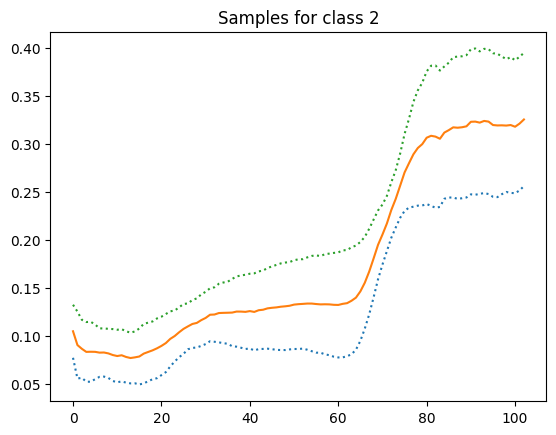

 94%|█████████▍| 93998/100000 [1:54:25<04:25, 22.60it/s]

Iter-94000; D_loss: -0.010187126696109772; G_loss: -0.05361803248524666; C_loss: 0.006572246551513672


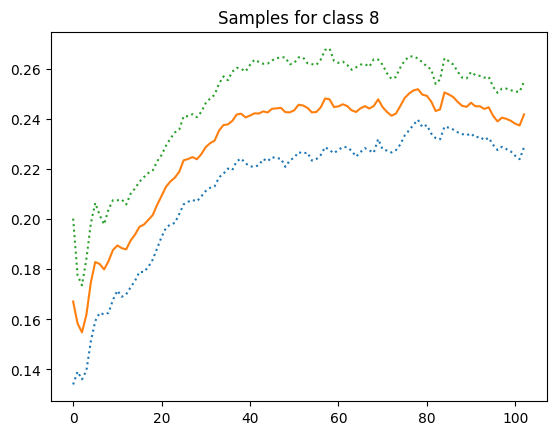

 95%|█████████▍| 94999/100000 [1:55:10<04:08, 20.15it/s]

Iter-95000; D_loss: -0.01272500865161419; G_loss: -0.042299605906009674; C_loss: 0.010197767056524754


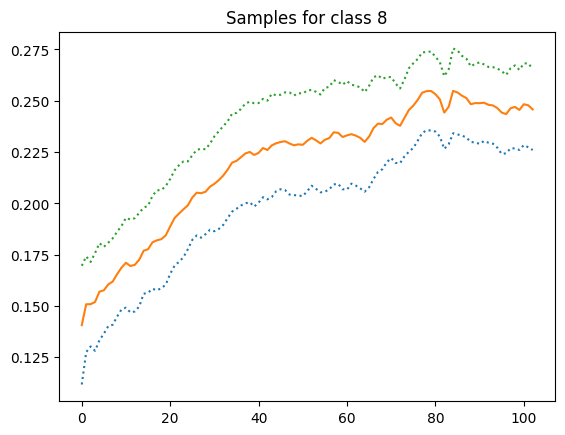

 96%|█████████▌| 96000/100000 [1:55:57<03:22, 19.74it/s]

Iter-96000; D_loss: -0.009228483773767948; G_loss: -0.045942872762680054; C_loss: 0.012255581095814705


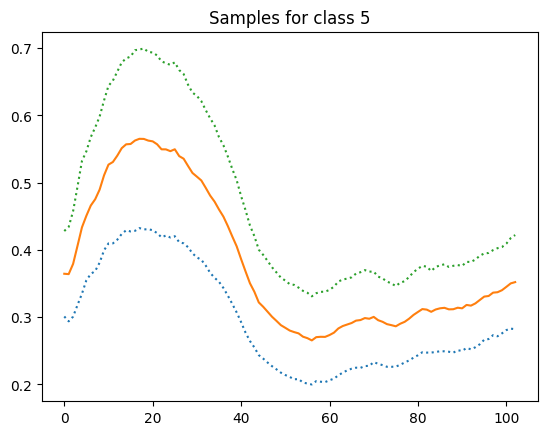

 97%|█████████▋| 97000/100000 [1:56:44<02:26, 20.46it/s]

Iter-97000; D_loss: -0.010444785468280315; G_loss: -0.0435064435005188; C_loss: 0.012253504246473312


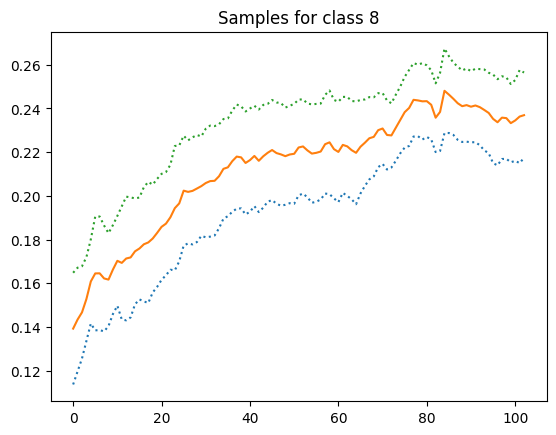

 98%|█████████▊| 97999/100000 [1:57:30<01:41, 19.71it/s]

Iter-98000; D_loss: -0.012997236102819443; G_loss: -0.05942603945732117; C_loss: 0.007770306896418333


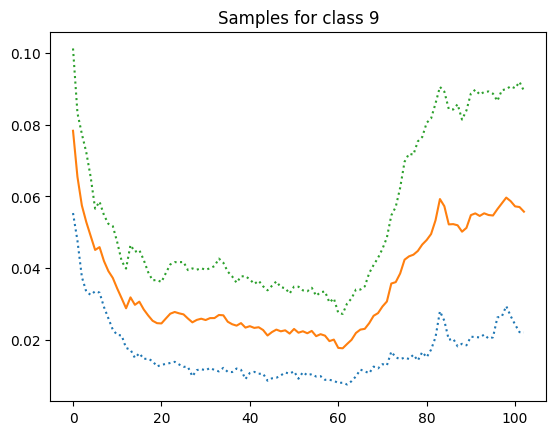

 99%|█████████▉| 99000/100000 [1:58:17<00:48, 20.69it/s]

Iter-99000; D_loss: -0.012225533835589886; G_loss: -0.05431780964136124; C_loss: 0.014920161105692387


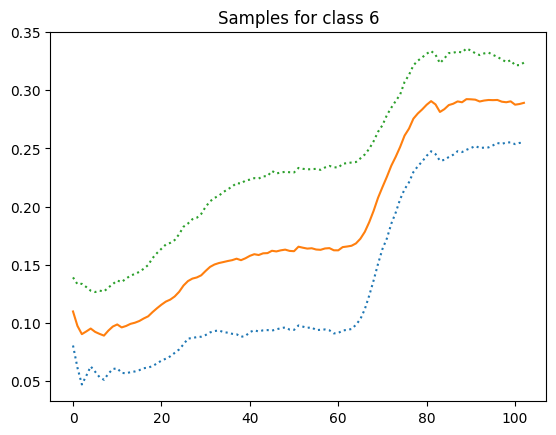

100%|██████████| 100000/100000 [1:59:03<00:00, 14.00it/s]


In [17]:
# 实例化生成器、判别器和分类器并移动到GPU
G = Generator().cuda()  # 生成器
D = Discriminator().cuda()  # 判别器
C = Classifier().cuda()  # 分类器

# 使用RMSProp优化器
G_solver = optim.RMSprop(G.parameters(), lr=lr)  # 为生成器设置RMSprop优化器
D_solver = optim.RMSprop(D.parameters(), lr=lr)  # 为判别器设置RMSprop优化器
C_solver = optim.RMSprop(C.parameters(), lr=lr)  # 为分类器设置RMSprop优化器

# 创建保存图片的目录
output_dir = os.path.join(current_dir, '111')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
    
# 开始训练迭代
for it in tqdm(range(100000)):  #requires_grad成员和.parameters()方法是属于nn.Module 的类的
    ###########################
    # (1) 更新分类器C和判别器D #
    ###########################
    for p in D.parameters():  # 重置D参数的requires_grad  
        p.requires_grad = True  # D的参数需要梯度
    for p in C.parameters():
        p.requires_grad = True  # C的参数需要梯度

    # 每次迭代训练d_step次判别器
    for _, (X, y), (X_, y_) in zip(range(d_step), data_loader, data_loader):  
        #zip 函数将多个可迭代对象合并在一起。这里它把 range(d_step), 第一个 data_loader 和第二个 data_loader 组合成一个新的迭代器
        #_ 是来自 range(d_step) 的循环索引，(X, y) 是第一个数据加载器的输出，而 (X_, y_) 是第二个数据加载器的输出
        D.zero_grad()  # 清空判别器的梯度

        # 采样随机噪声
        z = torch.randn(y.size(0), z_dim).squeeze()  # 随机噪声   z_dim = 30  y.size(0)；返回 N（批次大小）；squeeze() 函数用于去掉张量中所有大小为 1 的维度
        X, y = X.float(), y.float()  # 将输入数据转为float类型
        X_, y_ = X_.float(), y_.float()  # 第二批数据

        # Mixup 数据增强
        lam = np.random.beta(mixup_alpha, mixup_alpha)  # 从Beta分布中抽样  np.random.beta(a, b) 是 NumPy 库中的一个函数，用于从 Beta 分布中生成随机数。mixup_alpha = 0.1 
        X = lam * X + (1. - lam) * X_  # 生成混合样本  当 lam 较大时，生成的混合样本将更接近于 X；当 lam 较小时，生成的混合样本将更接近于 X_
        X, y, z = X.cuda(), y.cuda(), z.cuda()  # 移动到GPU
        y_ = y_.cuda()  # 移动第二批标签到GPU

        # 判别器对真实样本的预测
        D_real = D(X).mean()  #一个用于计算张量元素平均值的方法
        # 判别器对生成样本的预测
        fake_samples = G(z, y)  # 使用生成器生成假样本  z是噪声，y是label
        D_fake = D(fake_samples).mean()

        # 计算梯度惩罚
        gradient_penalty = calc_gradient_penalty(D, X.detach(), fake_samples.detach())

        # 计算判别器损失并反向传播
        D_loss = D_fake - D_real + gradient_penalty  # WGAN中的损失计算  D_loss 的目标是最大化判别器对真实样本的评分并最小化对生成样本的评分。
        flip = np.random.random() < flip_percentage  # 随机决定是否翻转标签
        if flip:
            # 翻转真实和假样本
            gradient_penalty = calc_gradient_penalty(D, fake_samples.detach(), X.detach())
            D_loss = D_real - D_fake + gradient_penalty

        D_loss.backward()  # 反向传播
        D_solver.step()  # 更新判别器参数

        ######################
        #  更新分类器C网络  #
        ######################
        C.zero_grad()  # 清空分类器的梯度
        # 获取类标签
        _, classes = torch.max(y, dim=1)  #y的形状通常为 (batch_size, num_classes)
        _, classes_ = torch.max(y_, dim=1)
        # 获取分类器的预测
        if flip:
            fake_samples = G(z, y)  # 生成假样本
            pred = C(fake_samples)  # 分类器对假样本的预测
            # 计算分类器损失并反向传播
            C_loss = F.cross_entropy(pred, classes, weight=class_weights)
        else:
            pred = F.log_softmax(C(X))  # 对真实样本应用log_softmax
            # 计算分类器损失（Mixup损失计算）
            C_loss = lam * F.nll_loss(pred, classes) + (1. - lam) * F.nll_loss(pred, classes_)

        C_loss.backward()  # 反向传播
        C_solver.step()  # 更新分类器参数


    ############################
    # (2) 更新生成器G网络     #
    ###########################
    for p in D.parameters():
        p.requires_grad = False  # 禁用判别器的参数计算，以避免梯度回传
    for p in C.parameters():
        p.requires_grad = False  # 禁用分类器的参数计算

    reset_grad(C, G, D)  # 重置梯度

    # 采样随机噪声
    z = torch.randn(y.size(0), z_dim).squeeze()  # 随机噪声
    z = z.cuda()  # 移动到GPU
    # 生成假样本
    G_sample = G(z, y)
    D_fake = D(G_sample)  # 判别器对生成样本的预测
    pred = C(G_sample)  # 分类器对生成样本的预测
    C_loss = F.cross_entropy(pred, classes, weight=class_weights)  # 计算分类器损失
    # 计算生成器损失以愚弄判别器 (WGAN)
    G_loss = -torch.mean(D_fake)  # WGAN生成器损失
    # 包括辅助分类器损失 (AC-GAN)
    loss = G_loss + c_weight * C_loss  # 总损失
    # 反向传播
    loss.backward()
    G_solver.step()  # 更新生成器参数

    # 每隔一定迭代次数打印和可视化结果
    if it % 1000 == 0:
        with torch.no_grad():
            # 打印当前损失
            print('Iter-{}; D_loss: {}; G_loss: {}; C_loss: {}'.format(it,
                                                                       D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy(),
                                                                       C_loss.data.cpu().numpy()))
            # 采样生成图像
            z = torch.randn(mb_size, z_dim).squeeze().cuda()  # 随机噪声
            c = np.zeros(shape=[mb_size, c_dim], dtype='float32')  # 创建类标签
            idx = np.random.randint(1, data_loader.dataset.n_classes)  # 随机选择一个类
            c[:, idx] = 1.  # 设置为对应类
            c = torch.from_numpy(c).squeeze().cuda()  # 转为torch tensor并移动到GPU
            samples = G(z, c).data.cpu().numpy()[:16]  # 生成样本
            
            pred = G(z, c)  # 生成器生成的样本
            plot_mean_std(samples)  # 绘制生成样本
            plt.title("Samples for class {}".format(idx))  # 显示标题
            plt.show()  # 展示图像

## Data generation

Now that the generator has been trained, we can generate some fake spectra and see how they fare visually against the real ones.

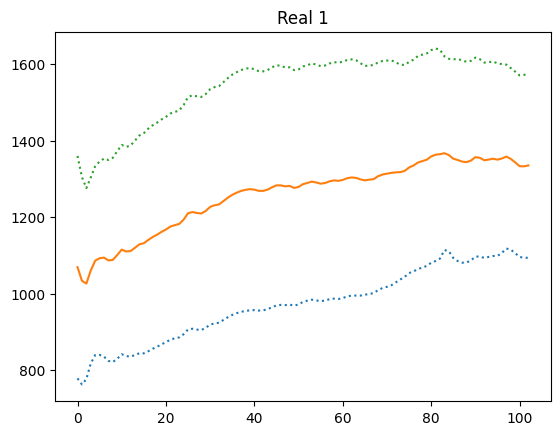

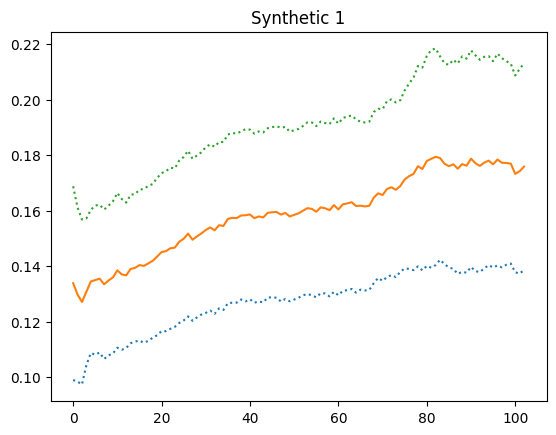

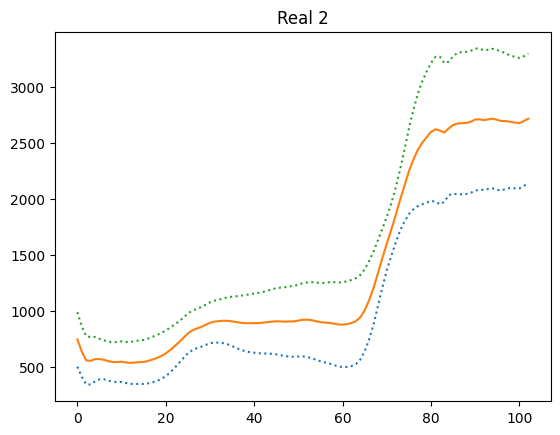

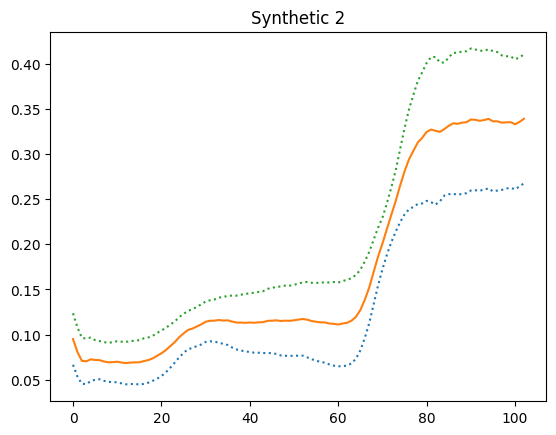

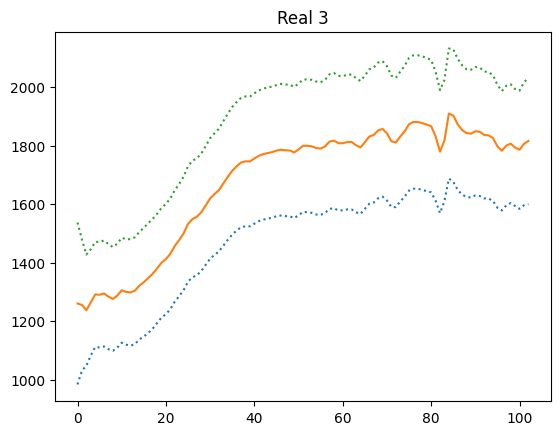

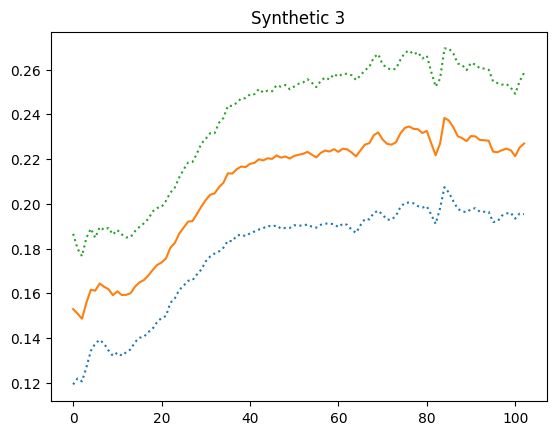

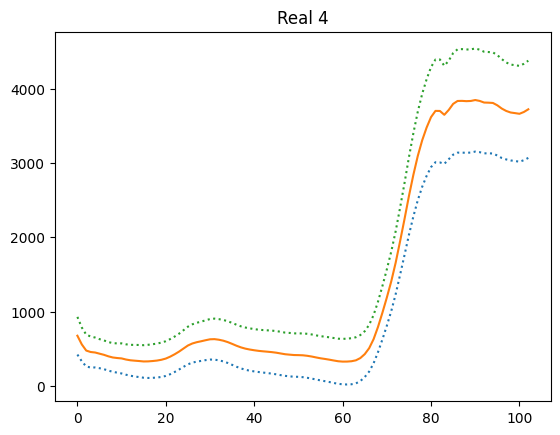

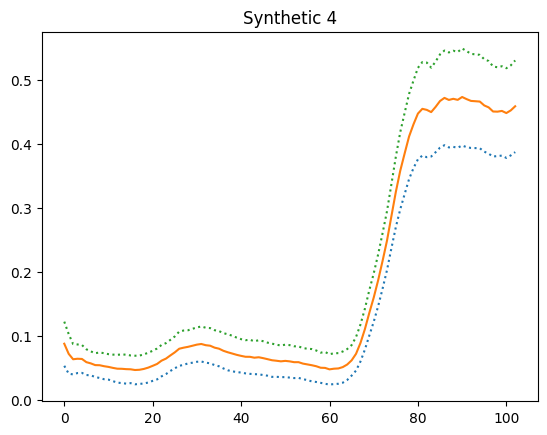

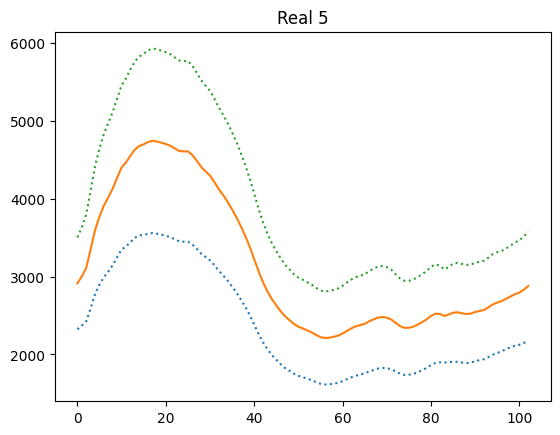

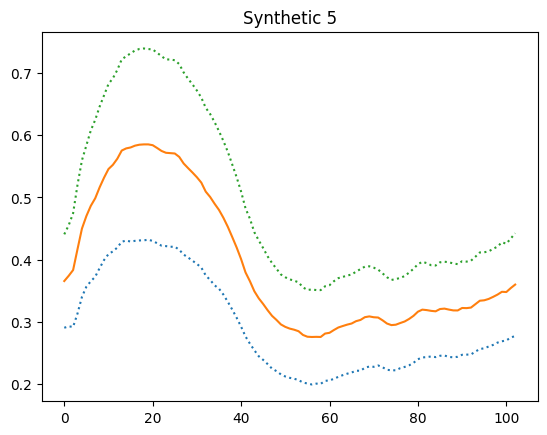

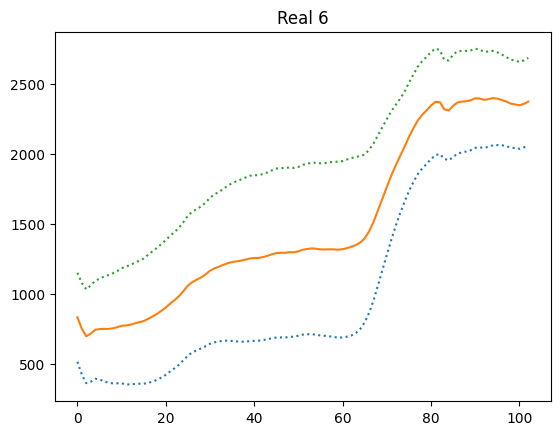

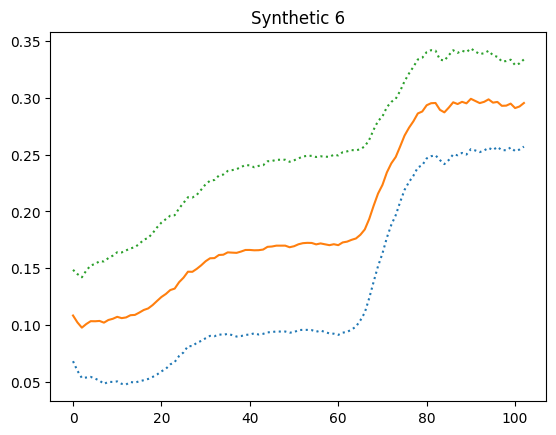

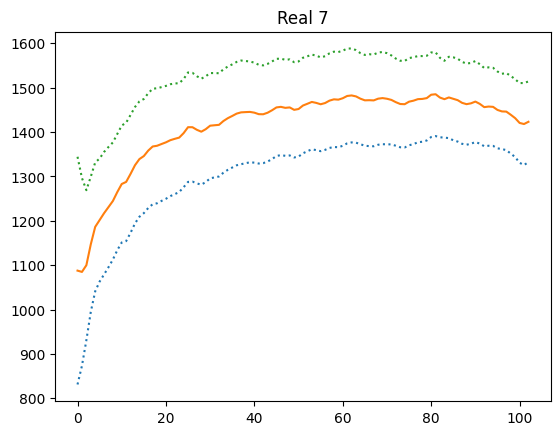

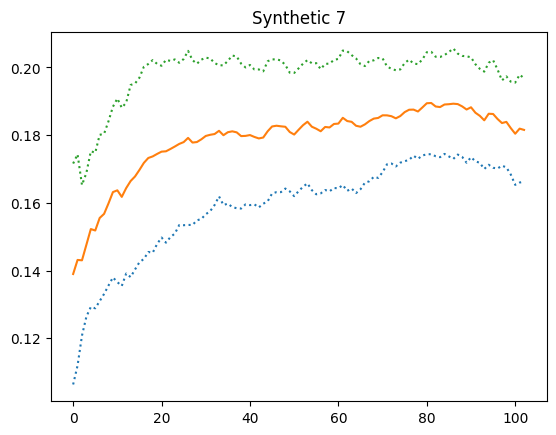

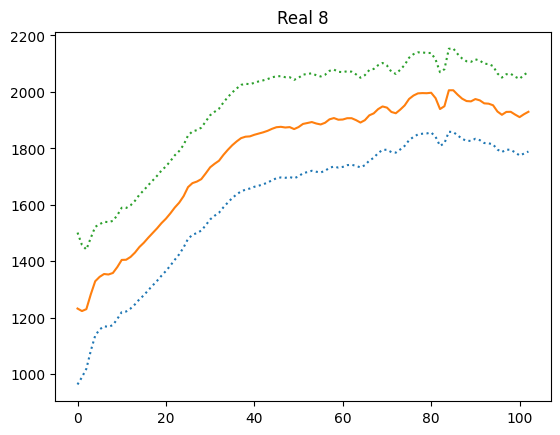

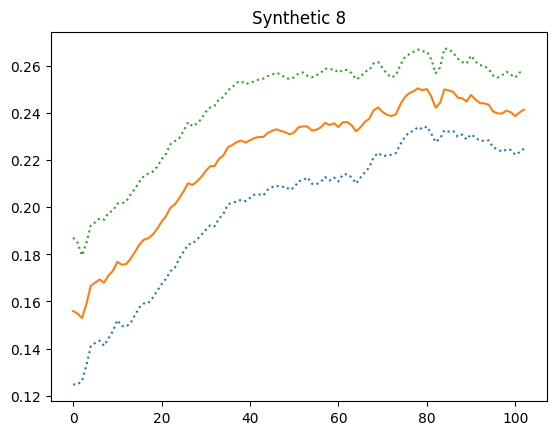

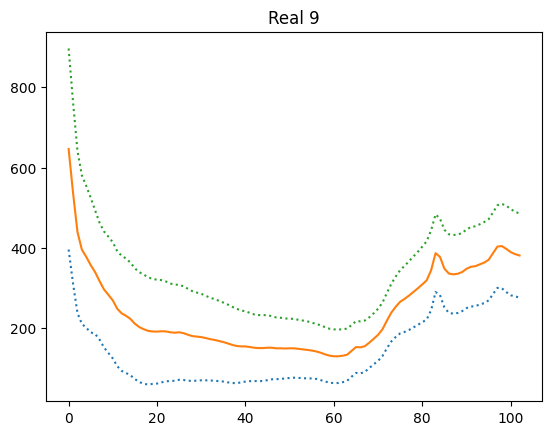

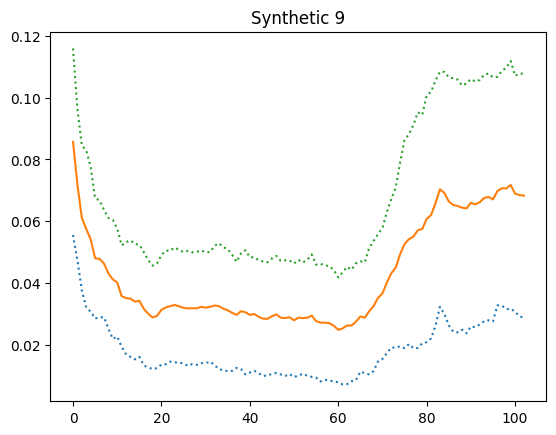

In [18]:
for c in np.unique(gt):
    # 0 is the "undefined" class
    if c == 0:
        continue
    
    # Get the mean spectrum +- std for this class
    spectras = img[gt == c, :]
    plot_mean_std(spectras)
    plt.title("Real {}".format(c))
    plt.show()
    
    # Get as many fake spectras as real ones
    synthetic_spectras = []
    with torch.no_grad():
        while len(synthetic_spectras) < len(spectras):
            z = torch.randn(mb_size, z_dim).cuda()
            y = torch.from_numpy(np.eye(data_loader.dataset.n_classes)[c]).float()
            y = y.unsqueeze(0).repeat(mb_size, 1).cuda()
            G_sample = G(z, y)
            _, classes = torch.max(y, 1)
            _, pred = torch.max(C(G_sample), 1)
            synthetic_spectras += list(G_sample.cpu().data.numpy())
    plt.show()
    plot_mean_std(synthetic_spectras)
    plt.title("Synthetic {}".format(c))
    plt.show()

## Evaluation

Finally, we want to compare the two distributions: is the fake distribution truely similar to the real distribution? To this end, we first can train a linear SVM on the real data and then apply it on the fake data. The frontiers of the real data should be respected by the fake data if the learning was successful.

In [19]:
import sklearn.svm
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.mixture

In [20]:
img = (img - img.min()) / (img.max() - img.min())
X_train = np.array([img[x,y] for x,y in zip(*np.nonzero(train_gt))])
y_train = np.array([gt[x,y] for x,y in zip(*np.nonzero(train_gt))])
X_test = np.array([img[x,y] for x,y in zip(*np.nonzero(test_gt))])
y_test = np.array([test_gt[x,y] for x,y in zip(*np.nonzero(test_gt))])

In [21]:
gmms = [sklearn.mixture.GaussianMixture(n_components=20) for _ in range(c_dim)]
for y in np.unique(y_train):
    gmms[y].fit(X_train[y_train == y])

We can uncomment this code to use Gaussian Mixture Models instead of GANs.

In [22]:
def gmm_create_fake_dataset(gmms, y):
    fake_X = []
    y_fake = []
    for y in np.unique(y):
        n_samples = np.count_nonzero(y_test == y)
        samples = gmms[y].sample(n_samples)[0]
        fake_X.append(samples)
        y_fake += [y] * n_samples
    fake_X = np.concatenate(fake_X)
    y_fake = np.array(y_fake)
    return fake_X, y_fake

#fake_X_train, fake_y_train = gmm_create_fake_dataset(gmms, y_train)
#fake_X_test, fake_y_test = gmm_create_fake_dataset(gmms, y_test)

### SVM on real data

Let's train a linear SVM on real data and see how it performs.

In [23]:
scaler = sklearn.preprocessing.StandardScaler()
svm = sklearn.svm.SVC()
#estimator = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm)])
estimator = sklearn.pipeline.Pipeline(steps=[('svm', svm)])
#tuned_parameters = {'svm__C': [0.1, 1, 10, 100, 1000], 'svm__kernel': ['linear']}
tuned_parameters = {'svm__C': [1000], 'svm__kernel': ['linear']}
clf = sklearn.model_selection.GridSearchCV(estimator, tuned_parameters, cv=5, n_jobs=4)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
best_params = clf.best_params_
print("The best SVM was obtained using {} and performed at {:.2f} accuracy.".format(best_params, 100 * score))

The best SVM was obtained using {'svm__C': 1000, 'svm__kernel': 'linear'} and performed at 90.17 accuracy.


In [24]:
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.89      0.92      0.90      6310
           2       0.93      0.96      0.95     17712
           3       0.81      0.75      0.78      1990
           4       0.92      0.90      0.91      2903
           5       0.98      0.99      0.99      1277
           6       0.87      0.79      0.83      4764
           7       0.78      0.62      0.69      1269
           8       0.82      0.86      0.84      3505
           9       1.00      1.00      1.00       894

    accuracy                           0.90     40624
   macro avg       0.89      0.87      0.88     40624
weighted avg       0.90      0.90      0.90     40624



### SVM on fake data

We now generate some fake data (in the same quantities as the real data) and apply the trained SVM on it.

In [25]:
def gan_create_fake_dataset(labels):
    with torch.no_grad():
        spectras = []
        for l in np.array_split(labels, len(labels) // mb_size):
            z = torch.randn(len(l), z_dim).cuda()
            y = np.zeros((len(l), data_loader.dataset.n_classes))
            for i, label in enumerate(l):
                y[i] = np.eye(data_loader.dataset.n_classes)[label]
            y = torch.from_numpy(y).float()
            eps = torch.randn(y.size())/10
            #y += eps
            y = y.cuda()
            G_sample = G(z, y)
            spectras += list(G_sample.cpu().data.numpy())
        return np.array(spectras), np.array(labels)

In [26]:
fake_X_train, fake_y_train = gan_create_fake_dataset(y_train)
fake_X_test, fake_y_test = gan_create_fake_dataset(y_test)

The true SVM performs better on fake data. Fake data is easier to separate, which means that it does not capture well boundaries between classes.

In [27]:
clf.score(fake_X_test, fake_y_test)

0.9464109885781804

In [28]:
y_fake_pred = clf.predict(fake_X_test)
from sklearn.metrics import classification_report
print(classification_report(fake_y_test, y_fake_pred))

              precision    recall  f1-score   support

           1       0.96      0.92      0.94      6310
           2       0.98      0.97      0.97     17712
           3       0.97      0.93      0.95      1990
           4       0.98      0.98      0.98      2903
           5       0.97      0.99      0.98      1277
           6       0.84      0.91      0.87      4764
           7       0.95      0.81      0.88      1269
           8       0.88      0.95      0.91      3505
           9       1.00      0.91      0.95       894

    accuracy                           0.95     40624
   macro avg       0.95      0.93      0.94     40624
weighted avg       0.95      0.95      0.95     40624



We can also train a "fake" SVM on fake data. It separates the fake data nearly perfectly. However, it also neatly separates the true data. It is not as good as the true SVM, but still relatively good for synthetic data.

In [29]:
svm_fake = sklearn.svm.SVC()
clf_fake = sklearn.pipeline.Pipeline(steps=[('svm', svm_fake)])
clf_fake.set_params(**clf.best_params_)
clf_fake.fit(np.concatenate([fake_X_train]), np.concatenate([fake_y_train]))

Pipeline(steps=[('svm', SVC(C=1000, kernel='linear'))])

In [30]:
clf_fake.score(fake_X_test, fake_y_test)

0.9913105553367467

In [31]:
clf_fake.score(X_test, y_test)

0.8726368649074439

## Data augmentation

We can train on both real and fake data to use the latter as augmented data. However, as we saw the fake data does not capture class boundaries very well. Therefore, it only skews the SVM and worsen the accuracy.

In [32]:
svm_augmented = sklearn.svm.SVC()
#clf_augmented = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm_augmented)])
clf_augmented = sklearn.pipeline.Pipeline(steps=[('svm', svm_augmented)])
clf_augmented.set_params(**clf.best_params_)
clf_augmented.fit(np.concatenate([X_train, fake_X_train]), np.concatenate([y_train, fake_y_train]))

Pipeline(steps=[('svm', SVC(C=1000, kernel='linear'))])

In [33]:
clf_augmented.score(X_test, y_test)

0.8995421425758172

## Statistical analysis

We can apply a PCA to both the real and fake datasets to visually compare them. The distributions in the 2D main components are fairly similar, which is good!

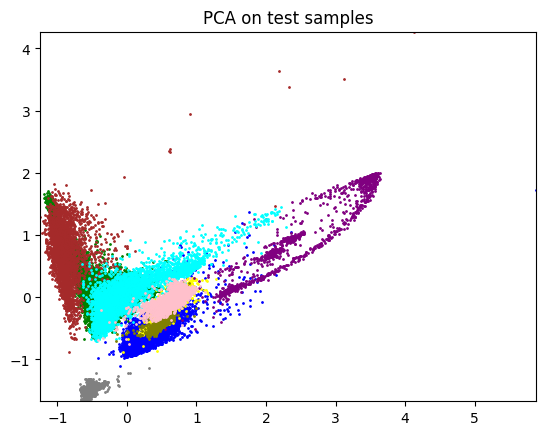

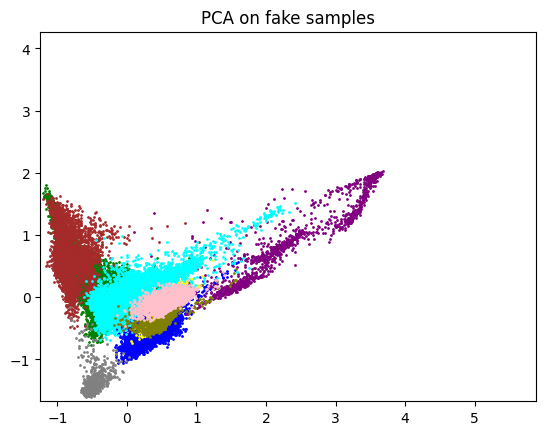

In [34]:
%matplotlib inline
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)
x_min, x_max = np.min(X_pca[:,0]), np.max(X_pca[:,0])
y_min, y_max = np.min(X_pca[:,1]), np.max(X_pca[:,1])

colors = ['red', 'blue', 'green', 'yellow', 'brown', 'purple', 'cyan', 'olive', 'pink', 'gray']
for i, color in enumerate(colors):
    idx = y_test == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, s=1)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on test samples')
plt.show()

X_fake_pca = pca.transform(fake_X_test)
for i, color in enumerate(colors):
    idx = fake_y_test == i
    plt.scatter(X_fake_pca[idx, 0], X_fake_pca[idx, 1], s=1, c=color)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on fake samples')
plt.show()

We can train a neural network classifier on the real dataset and the augmented dataset (real + fake).

In [35]:
def train(net, X_train, y_train, epochs=100):
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(),
                                             torch.from_numpy(y_train).long())
    loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)
    solver = optim.Adam(net.parameters(), amsgrad=True)
    net.train()
    it = 0
    losses = []
    for _ in tqdm(range(epochs)):
        for X, y in loader:
            it += 1
            net.zero_grad()
            X, y = X.cuda(), y.cuda()
            out = net(X)
            loss = F.cross_entropy(out, y)
            loss.backward()
            solver.step()
            losses.append(loss.item())
            if it % 10000 == 0:
                print("Loss at {} = {}".format(it, loss.item()))
                plt.plot(losses) and plt.show()
    return net

 33%|███▎      | 3328/10000 [00:51<01:33, 71.27it/s]

Loss at 10000 = 0.03624216094613075


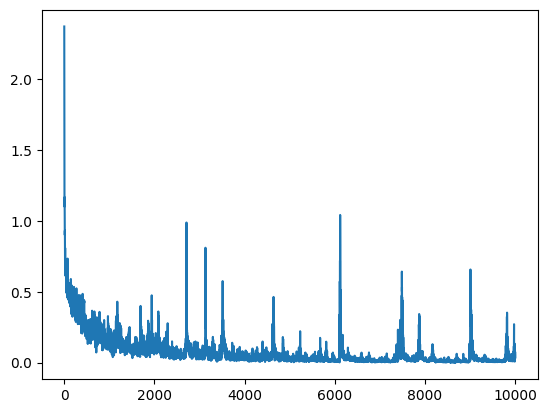

 67%|██████▋   | 6663/10000 [01:43<00:54, 61.28it/s]

Loss at 20000 = 0.0008935654768720269


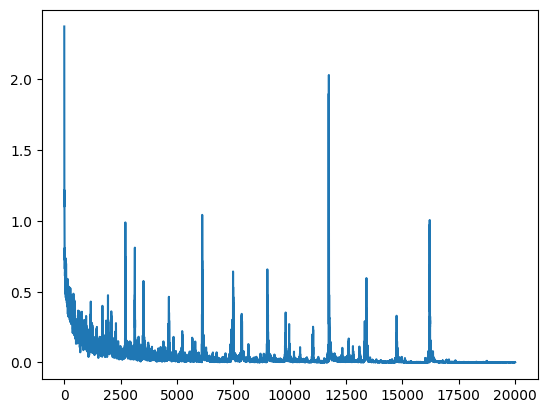

100%|█████████▉| 9993/10000 [02:33<00:00, 62.70it/s]

Loss at 30000 = 0.00016826149658299983


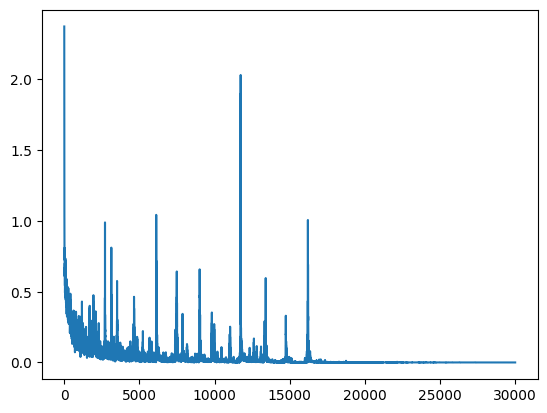

100%|██████████| 10000/10000 [02:34<00:00, 64.91it/s]


In [36]:
C_real = train(Classifier().cuda(), X_train, y_train, epochs=10000)

In [37]:
def test(net, X_test, y_test):
    with torch.no_grad():
        net.eval()
        print(X_test.shape)
        print(y_test.shape)
        dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(),
                                                 torch.from_numpy(y_test).long())
        loader = torch.utils.data.DataLoader(dataset, batch_size=mb_size)
        pred = []
        for X, y in loader:
            X, y = X.cuda(), y.cuda()
            out = net(X)
            _, out = torch.max(out, 1)
            pred.append(out.cpu().numpy())
        pred = np.concatenate(pred)
        print(classification_report(y_test, pred, digits=4))
    return pred

In [38]:
test(C_real, X_test, y_test)

(40624, 103)
(40624,)
              precision    recall  f1-score   support

           1     0.9392    0.9257    0.9324      6310
           2     0.9706    0.9751    0.9728     17712
           3     0.8255    0.8246    0.8250      1990
           4     0.9502    0.9525    0.9513      2903
           5     0.9882    0.9851    0.9867      1277
           6     0.9131    0.9133    0.9132      4764
           7     0.8542    0.8676    0.8608      1269
           8     0.8662    0.8645    0.8653      3505
           9     1.0000    0.9933    0.9966       894

    accuracy                         0.9390     40624
   macro avg     0.9230    0.9224    0.9227     40624
weighted avg     0.9390    0.9390    0.9390     40624



array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

 20%|█▉        | 1998/10000 [00:57<04:08, 32.26it/s]

Loss at 10000 = 0.0063448743894696236


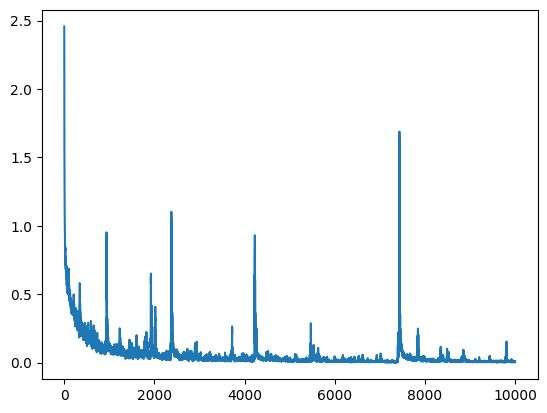

 40%|███▉      | 3997/10000 [01:54<02:40, 37.38it/s]

Loss at 20000 = 0.0007133000181056559


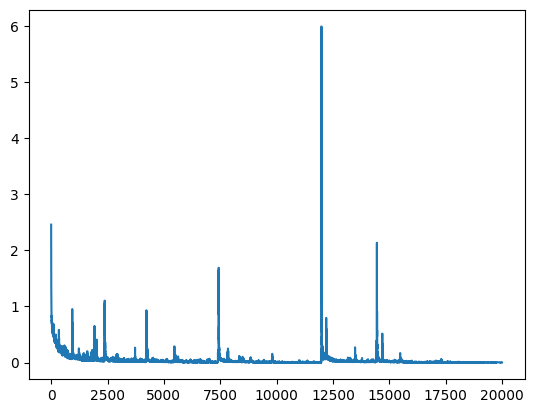

 60%|█████▉    | 5997/10000 [02:52<01:51, 35.90it/s]

Loss at 30000 = 0.00026669944054447114


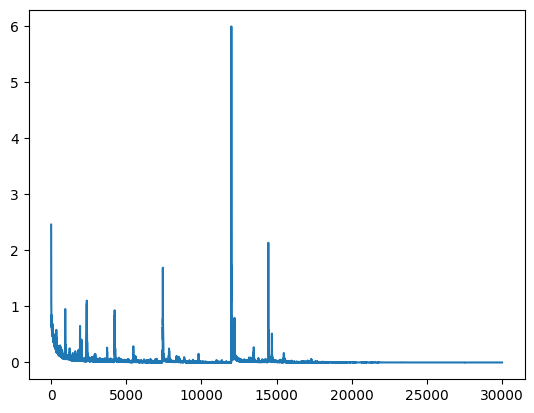

 80%|███████▉  | 7997/10000 [03:51<01:00, 32.85it/s]

Loss at 40000 = 0.00012751767644658685


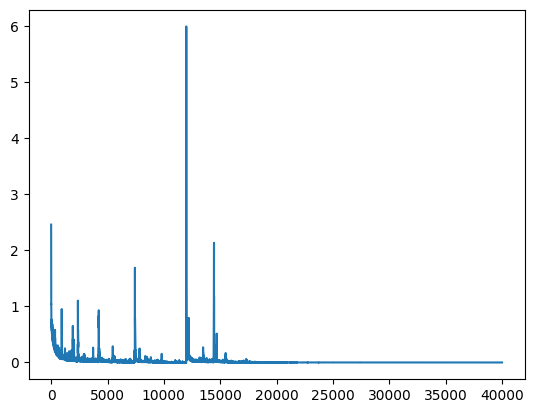

100%|█████████▉| 9998/10000 [04:49<00:00, 36.45it/s]

Loss at 50000 = 7.4405426857993e-05


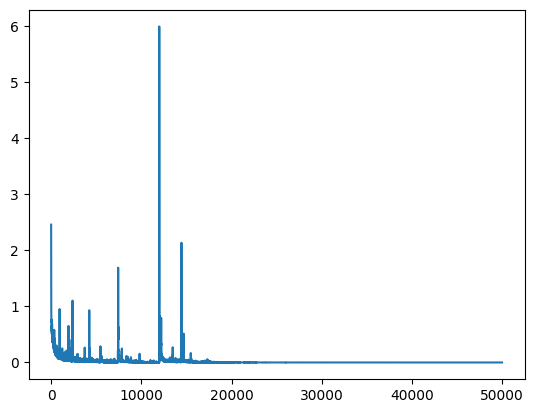

100%|██████████| 10000/10000 [04:49<00:00, 34.58it/s]


In [39]:
C_fake = train(Classifier().cuda(), np.concatenate((X_train, fake_X_train)), np.concatenate((y_train, fake_y_train)), epochs=10000)

The augmented classifier seems to work at least as well as the original one. This is encouraging for using GANs as a data augmentation strategy in a weakly-supervised hyperspectral image classification context.

In [40]:
test(C_fake, X_test, y_test)

(40624, 103)
(40624,)
              precision    recall  f1-score   support

           1     0.9448    0.9469    0.9459      6310
           2     0.9710    0.9775    0.9743     17712
           3     0.8318    0.7925    0.8116      1990
           4     0.9549    0.9556    0.9552      2903
           5     0.9992    0.9789    0.9889      1277
           6     0.9247    0.9177    0.9212      4764
           7     0.9222    0.8684    0.8945      1269
           8     0.8535    0.8776    0.8654      3505
           9     1.0000    0.9955    0.9978       894

    accuracy                         0.9435     40624
   macro avg     0.9336    0.9234    0.9283     40624
weighted avg     0.9434    0.9435    0.9434     40624



array([1, 1, 1, ..., 2, 2, 2], dtype=int64)